#  Top-down sampling with priority queue and direct optimization 


##  MiniGrid Environment

In [1]:
import gym
from gym_minigrid.register import env_list
from gym_minigrid.minigrid import Grid
# Test specifically importing a specific environment
from gym_minigrid.envs import DoorKeyEnv

from gym_minigrid.wrappers import *


In [2]:

#env_path = 'MiniGrid-DoorKey-6x6-v0'
#env_path = 'MiniGrid-Empty-6x6-v0' 
env_path = 'MiniGrid-MultiRoom-N6-v0'
env = gym.make(env_path)


## Policy model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import collections
import heapq

import random
import copy
import time


In [4]:
seed = 2
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [5]:
class Policy(nn.Module):
    def __init__(self, action_space):
        super(Policy, self).__init__()
        
        self.image_embedding_size = 64
        self.number_directions = 4

        self.image_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3, 3))           
        )

        self.fc = nn.Sequential(
            
            nn.Linear(self.image_embedding_size+self.number_directions, action_space.n)

        )
        
    def forward(self,batch_obs):
        images = []
        directions = []
        for obs in batch_obs:
            image = np.array([obs["image"]])
            image = torch.tensor(image,dtype=torch.float)
            x = torch.transpose(torch.transpose(image, 1, 3), 2, 3)
            images.append(x)
            
            direction = torch.LongTensor([obs["direction"]]).unsqueeze(0)
            direction = torch.FloatTensor(direction.size(0),self.number_directions).zero_().scatter_(-1, direction,1.0)
            directions.append(direction)
        x = torch.cat(images)
        direction = torch.cat(directions)
        x = self.image_conv(x)
        x = x.view(x.size(0), -1)
        image_direction = torch.cat((x,direction),dim=1)
        logits = self.fc(image_direction)

        return F.log_softmax(logits,dim=-1)

policy = Policy(env.action_space)


In [6]:
num_actions = env.action_space
observation = env.reset()
policy([observation])


tensor([[-1.9878, -1.9404, -1.9419, -1.7624, -2.1419, -1.8559, -2.0360]],
       grad_fn=<LogSoftmaxBackward>)

In [7]:
def save_checkpoint(model,optimizer,filepath):
    state = {
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    torch.save(state, filepath)

def load_checkpoint(model,optimizer,filepath):
    # "lambda" allows to load the model on cpu in case it is saved on gpu
    state = torch.load(filepath,lambda storage, loc: storage)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    return model,optimizer

## Top-down construction 

In [8]:
def sample_gumbel(mu):
    """Sample a Gumbel(mu)."""    
    return -np.log(np.random.exponential()) + mu


def sample_truncated_gumbel(mu, b):
    """Sample a Gumbel(mu) truncated to be less than b."""    
    return -np.log(np.random.exponential() + np.exp(-b + mu)) + mu

  
def sample_gumbel_argmax(logits):
    """Sample from a softmax distribution over logits.

    TODO: check this is correct.

    Args:
    logits: A flat numpy array of logits.

    Returns:
    A sample from softmax(logits).
    """
    phi_x_g = -np.log(np.random.exponential(size=logits.shape)) + logits
    argmax = np.argmax(phi_x_g)
    return phi_x_g,argmax


def logsumexp(logits):
    c = np.max(logits)
    return np.log(np.sum(np.exp(logits - c))) + c


def log_softmax(logits, axis=1):
    """Normalize logits per row so that they are logprobs.
  
      TODO: check this is correct. 
    """
    maxes = np.max(logits, axis=axis, keepdims=True)
    offset_logits = logits - maxes
    log_zs = np.log(np.sum(np.exp(offset_logits), axis=axis, keepdims=True))
    return offset_logits - log_zs

In [9]:
# Make a node without a state, and also don't allow `next_actions` to be None.
# Just put in all possible next actions when the node is created.

# Namedtuple for storing results
Trajectory = collections.namedtuple('Trajectory', ['actions','states','gumbel','reward','status','node'])

class Node:
    epsilon = 1.0
    discount = 0.99
    def __init__(self,
                 env,
                 states,
                 prefix=[],                 
                 reward_so_far=0,
                 done=False,
                 logprob_so_far=0,
                 max_gumbel=sample_gumbel(0),
                 next_actions=range(num_actions.n),
                 t_opt=True):
        
        self.env = env  
        self.prefix = prefix
        self.states = states
        self.reward_so_far = reward_so_far
        self.done = done
        self.logprob_so_far = logprob_so_far
        self.max_gumbel = max_gumbel
        self.next_actions = next_actions
        
        self.t_opt = t_opt
        self.priority = self.epsilon*self.reward_so_far*self.discount**len(self.prefix)+ self.max_gumbel
        

    def __lt__(self, other):
        if self.t_opt == other.t_opt: #false==false
            return self.priority >  other.priority
        
        elif self.t_opt:
            """
            This is how we sample t_opt, the starting node is with t_opt=True and
            its 'special child' will be also with t_opt=True and because we always returning true
            when we compare it to the 'other childrens' (where t_opt=False) the special path is sampled (speical childs only) 
            """
            return True
            
        


In [10]:
def sample_t_opt_and_search_for_t_direct(policy_model,
                                         environment,
                                         num_actions,
                                         max_trajectory_length,
                                         max_search_time=20,
                                         epsilon=1.0,
                                         inference=False):
    """Samples an independent Gumbel(logprob) for each trajectory in top-down-ish order.

    Args:
        policy_model: Pytorch model that gets state and returns actions logits
        environment: Initial environment that initialized with random seed
        num_actions: Number of possible actions, should be equal to the policy output size
        max_trajectory_length: Maximum length of a trajectory to allow.
        max_search_time: Maximum searching time of t_direct
        epsilon: direct optimization parameter
        inference: sampling t_opt without searching for t_direct
    Returns:
        y_opt: trajectory of max gumbel 
        y_direct: trajectory of max gumbel + reward*epsilon (target)
        final_trajectories: int, number of all trajectories (can be deleted, just for debugging)
    """
    to_print = False
    Node.epsilon = 3 #epsilon
    root_node = Node(
        env = environment,
        states = [environment.reset()],
        max_gumbel=sample_gumbel(0))
    
    queue = []    
    heapq.heappush(queue,root_node)
       
    #heapq.heappush(queue,root_node)
    max_gumbel_eps_reward ,max_gumbel= -float('Inf'),-float('Inf')
    final_trajectories = []
    
    start_time = time.time()
    while queue:
        if to_print:
            print(10*'-')
            for q in queue:                
                print(q.priority,q.t_opt,'|',q.prefix,q.reward_so_far,q.logprob_so_far,q.max_gumbel,q.next_actions)           
        
        parent = heapq.heappop(queue)
        if inference and not parent.t_opt:
            t_direct=None
            break 

        if  len(parent.prefix) == max_trajectory_length or parent.done:
            t = Trajectory(actions=parent.prefix,
                           states=parent.states,
                           gumbel=parent.max_gumbel,
                           reward=parent.reward_so_far,
                           status=parent.done,
                           node = parent)
            assert len(t.actions) == len(parent.states)-1            
            if parent.t_opt:
                t_opt = t
                value_to_stop = t_opt.node.priority
            else:                
                final_trajectories.append(t)                
                if parent.priority>max_gumbel_eps_reward:
                    max_gumbel_eps_reward = parent.priority
                    t_direct = t                    
                    if  parent.priority>value_to_stop:
                        if to_print:
                            print('stop!!', parent.done,parent.priority,value_to_stop)
                            print('*'*100)
                        #print (len(final_trajectories),above_max)
                        break
            continue
            
        if time.time()-start_time>max_search_time:
            if len(final_trajectories)==0:                
                t_direct = Trajectory(actions=parent.prefix,
                           states=parent.states,
                           gumbel=parent.max_gumbel,
                           reward=parent.reward_so_far,
                           status=parent.done,
                           node = parent)
                final_trajectories.append(t_direct)                
            break

        current_state = parent.states[-1]   
        with torch.no_grad():
            policy_model.eval()
            action_logprobs = policy_model([current_state]).numpy().squeeze(0)
        
        next_action_logprobs = action_logprobs[parent.next_actions]
        
        maxval,special_action_index = sample_gumbel_argmax(next_action_logprobs)
        
        special_action = parent.next_actions[special_action_index]
        special_action_logprob = action_logprobs[special_action]
        
        env_copy = copy.deepcopy(parent.env) # do it here, before the step
        new_state,reward,done,info = parent.env.step(special_action)
        reward = 100*reward
        special_child = Node(
                             env = parent.env,
                             prefix=parent.prefix + [special_action],
                             states=parent.states + [new_state],
                             reward_so_far=parent.reward_so_far + reward,
                             done=done,
                             logprob_so_far=parent.logprob_so_far + special_action_logprob,
                             max_gumbel=parent.max_gumbel, 
                             next_actions=range(num_actions.n),# All next actions are possible.
                             t_opt = parent.t_opt) 

        
        heapq.heappush(queue,special_child)
        # Sample the max gumbel for the non-chosen actions and create an "other
        # children" node if there are any alternatives left.

        other_actions = [i for i in parent.next_actions if i != special_action]
        assert len(other_actions) == len(parent.next_actions) - 1

        if other_actions:
            
            other_max_location = logsumexp(action_logprobs[other_actions])
            other_max_gumbel = sample_truncated_gumbel(parent.logprob_so_far + other_max_location, 
                                                     parent.max_gumbel)
            
            other_children = Node(
                                env = env_copy,
                                prefix=parent.prefix,
                                states=parent.states,
                                reward_so_far=parent.reward_so_far,
                                done=parent.done,
                                logprob_so_far=parent.logprob_so_far,
                                max_gumbel=other_max_gumbel,
                                next_actions=other_actions,
                                t_opt = False) 
        
            heapq.heappush(queue,other_children)

    return t_opt, t_direct,final_trajectories



In [11]:
#policy = Policy(env.action_space)
init_env = gym.make(env_path)
init_env.seed(8)

t_opt, t_direct,final_trajectories = sample_t_opt_and_search_for_t_direct(policy,
                                                                          init_env,                                                                          
                                                                          num_actions,
                                                                          max_trajectory_length=7,
                                                                          epsilon=1.0)




print (len(final_trajectories))
print (len(t_opt.actions))
print (len(t_direct.actions))
print (t_opt.actions,t_opt.reward,t_opt.node.done)
print (t_direct.actions,t_direct.reward,t_direct.node.done)


3054
7
7
[4, 2, 3, 1, 4, 1, 5] 0 False
[6, 2, 4, 0, 2, 4, 1] 0 False


## Direct optimization 

In [12]:
def direct_optimization_loss(policy_model,t_opt,t_direct,epsilon=1.0):
    """computes \nabla \phi(a,s) = \sum_{t=1}^T \nabla \phi(a_t, s_t) with direct optimization
    
    Args:
        policy_model: Pytorch model gets state and returns actions logits 
        t_opt: trajectory with the max(gumbel)
        t_direct: trajectory with the max(gumbel+epsilon*reward) 
        epsilon: for direct optimization, usually between 0.9-1.0
    Returns: 
        logits multiplied with vector of (1,0,..,-1) [for example]
        so when we derive it with backward we ends up with \nabla \phi_opt(a,s) - \nabla \phi_direct(a,s)"""
    direct_states  = t_direct.states[:-1]
    opt_states  = t_opt.states[:-1]
    opt_direct_states = (opt_states+direct_states)
    
    direct_actions = torch.LongTensor(t_direct.actions).view(-1,1)
    opt_actions = torch.LongTensor(t_opt.actions).view(-1,1)    
    
    phi = policy_model(opt_direct_states) # gets the logits so the network will calculates weights gradients
    y_direct =  -torch.FloatTensor(direct_actions.size(0),phi.size(1)).zero_().scatter_(-1,direct_actions,1.0) # one-hot that points to the best direction
    y_opt = torch.FloatTensor(opt_actions.size(0),phi.size(1)).zero_().scatter_(-1, opt_actions,1.0)
    
    y_opt_direct = torch.cat((y_opt,y_direct))
    y_opt_direct = y_opt_direct*(1.0/epsilon)    

    policy_loss = torch.sum(y_opt_direct*phi)   
    return policy_loss

## Training 

In [13]:
def run_episode(actions_list,env,seed):
    """Interacts with the environment given actions """
    rewards = 0
    done = False
    success = False
    env.seed(seed)
    state = env.reset()
    for action in actions_list: 
        state, reward, done,info = env.step(action)
        if done and reward == 1.0 :
            success = True

        rewards += reward
    return rewards,success

In [14]:
#@timing
def train_policy_model(init_env,policy_model,optimizer,num_episodes=500,max_trajectory_length=4,epsilon=1.0,seed = 1234):
   
    success = 0    
    rewards = []
    k_direct_star = []    
    for episode in range(num_episodes):        
        init_env.seed(seed)
        print('episode: ',episode)        
        t_opt, t_direct,final_trajectories = sample_t_opt_and_search_for_t_direct(policy_model,
                                                                                  init_env,
                                                                                  num_actions,
                                                                                  max_trajectory_length=max_trajectory_length)  
                                                                                                                                        
    
        if t_direct.node.priority > t_opt.node.priority:
            policy_model.train()
            policy_loss = direct_optimization_loss(policy_model = policy_model,
                                                   t_opt=t_opt,
                                                   t_direct=t_direct,
                                                   epsilon=epsilon)

            optimizer.zero_grad()
            policy_loss.backward()
            optimizer.step()


        trajectory_reward,suc = run_episode(t_opt.actions,init_env,seed)        
        success += suc        
        print ('opt reward: {},success: {}, length: {}, priority: {:.3f}'.format(trajectory_reward,suc,len(t_opt.actions),t_opt.node.priority))
        t_direct_reward,suc = run_episode(t_direct.actions,init_env,seed)
        print ('direct reward: {},success: {}, length: {}, priority: {:.3f}'.format(t_direct_reward,suc,len(t_direct.actions),t_direct.node.priority))
        rewards.append(trajectory_reward)
        seed+=1
    
    #save_checkpoint(policy_model,optimizer,'policy_state_dicts_multiroom.pkl')
    return policy_model,success,rewards,k_direct_star



In [15]:

policy = Policy(num_actions)
optimizer = optim.Adam(policy.parameters(), lr=0.001)
#load_checkpoint(policy,optimizer,'policy_state_dicts_doorkey.pkl')
load_checkpoint(policy,optimizer,'saved_models/policy_state_dicts_multiroom.pkl')

init_env = gym.make(env_path)
policy,num_success,rewards,k_direct_star = train_policy_model(init_env,
                                                              policy,
                                                              optimizer,
                                                              num_episodes=5,
                                                              max_trajectory_length=300,
                                                              epsilon=0.3,
                                                              seed = 1034)


print (num_success,np.max(rewards)) # number of times the player has reached the goal

episode:  0
opt reward: 0.6,success: False, length: 240, priority: 16.056
direct reward: 0.8999999999999999,success: False, length: 21, priority: 205.925
episode:  1
opt reward: 2.5,success: True, length: 118, priority: 228.951
direct reward: 2.5,success: True, length: 119, priority: 196.627
episode:  2
opt reward: 2.5,success: True, length: 51, priority: 448.615
direct reward: 2.5,success: True, length: 52, priority: 437.975
episode:  3
opt reward: 2.5,success: True, length: 57, priority: 422.031
direct reward: 2.5,success: True, length: 58, priority: 408.976
episode:  4
opt reward: 2.55,success: True, length: 122, priority: 227.191
direct reward: 2.55,success: True, length: 108, priority: 226.298
4 2.55


## Visualization

In [16]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb


In [17]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))   


In [18]:
def play(policy,section_length,sample_opt = True,seed=1234):
    
    env = gym.make(env_path)
    env.seed(seed)
    t_opt,t_direct,_ = sample_t_opt_and_search_for_t_direct(policy,
                                                            env,
                                                            num_actions,
                                                            max_trajectory_length=section_length,
                                                            epsilon=1.0,
                                                            inference =sample_opt)
    
    actions = t_opt.actions if sample_opt else t_direct.actions
    print (actions)
    
    env.seed(seed)    
    state = env.reset()
    done = False
    frames = []
    total_reward = 0
    frames.append(env.render(mode = 'rgb_array'))
    for action in actions: 
        state, reward, done,info = env.step(action)
        frames.append(env.render(mode = 'rgb_array'))
        total_reward += reward
        if done:
            break
    print ('total reward: ',total_reward )
    env.render()
    display_frames_as_gif(frames)


[2, 0, 2, 1, 5, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 5, 2, 2, 2, 2, 2, 1, 5, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 5, 2, 2, 2, 2, 1, 2, 2]
total reward:  2.5



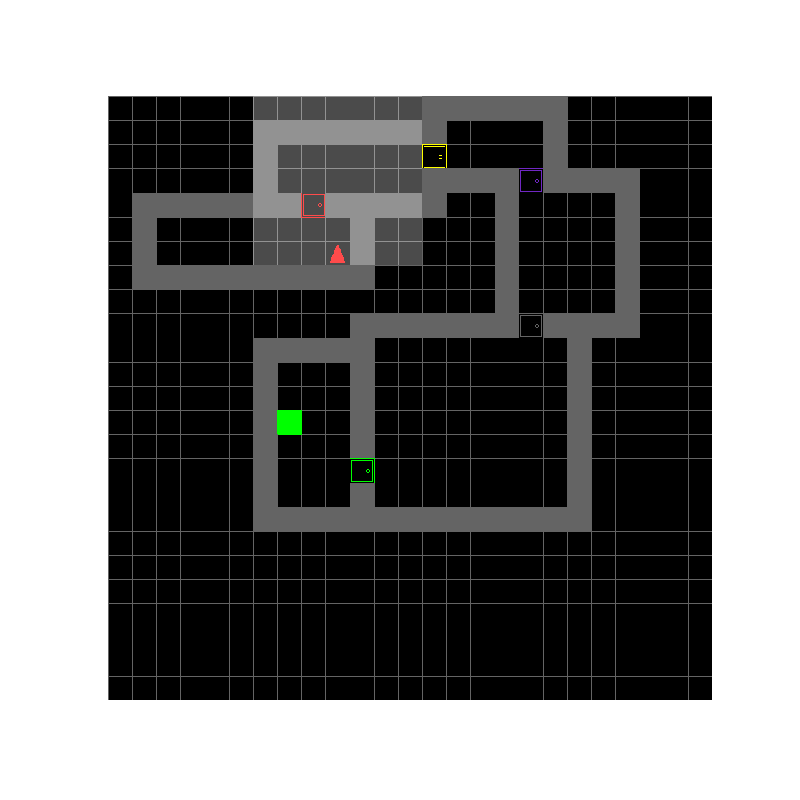
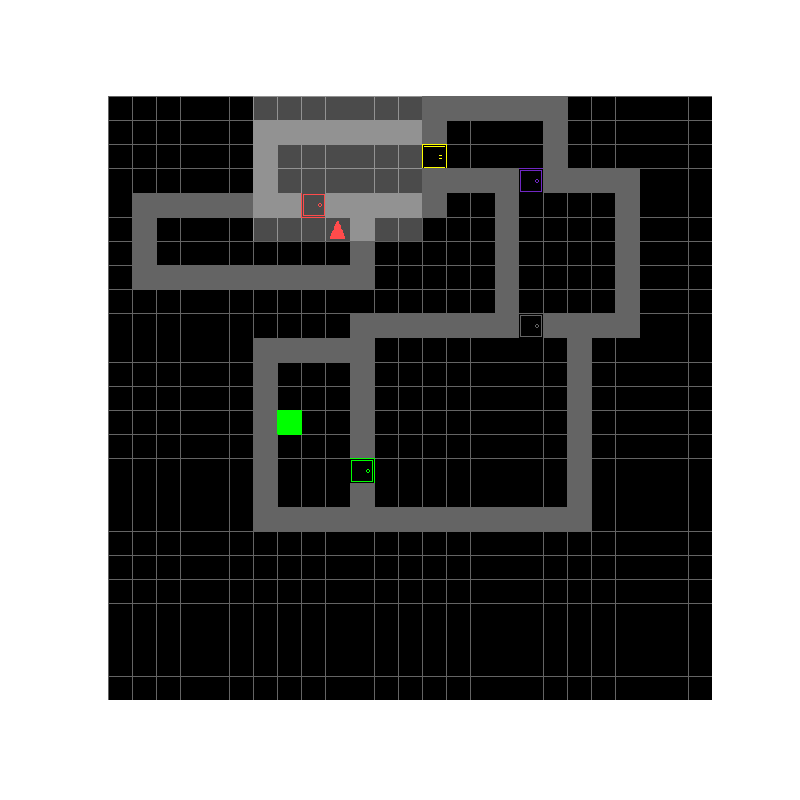
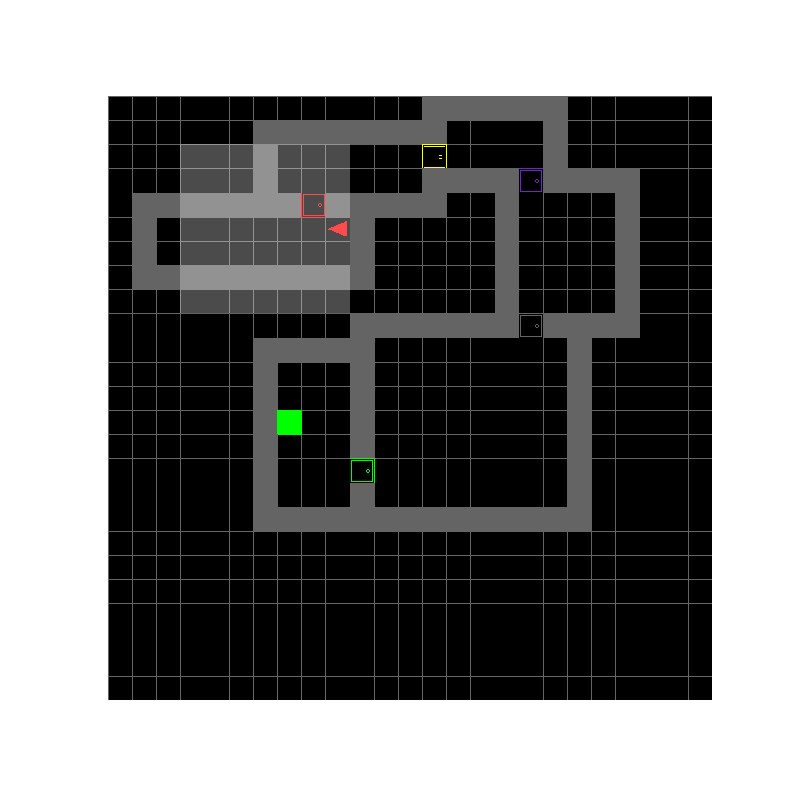
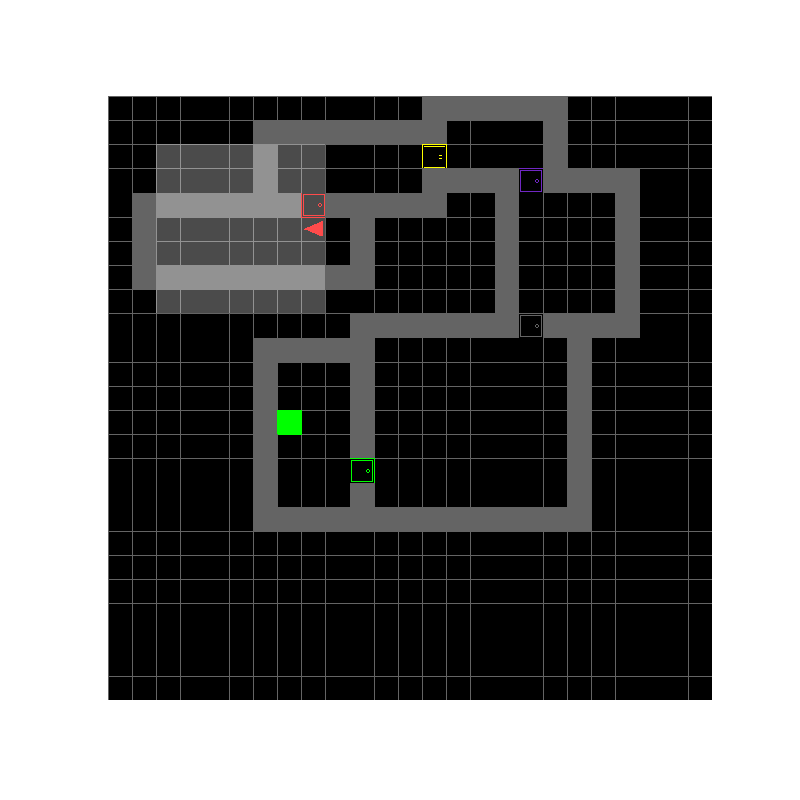
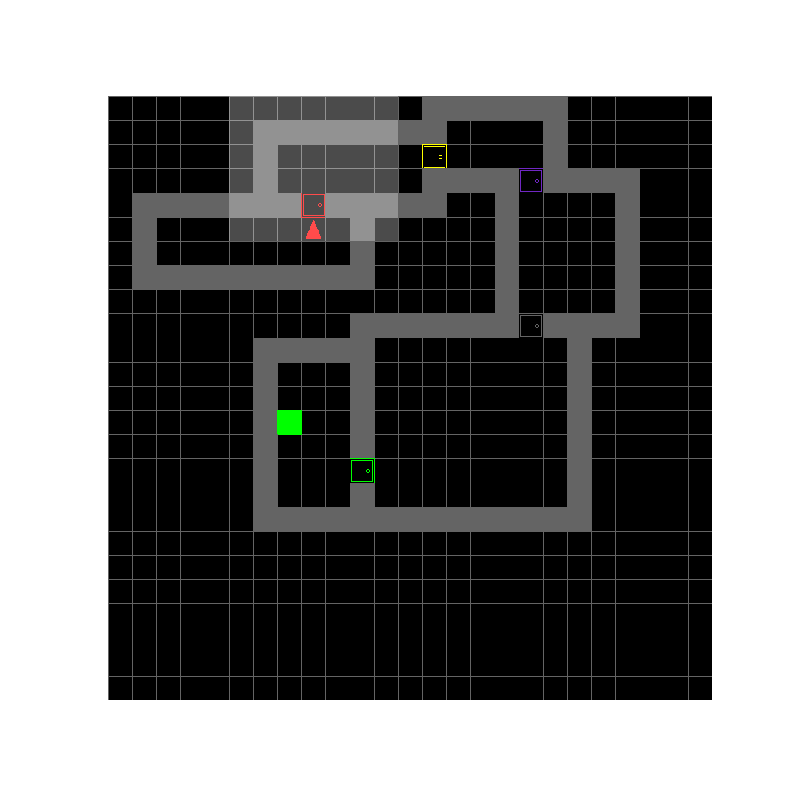
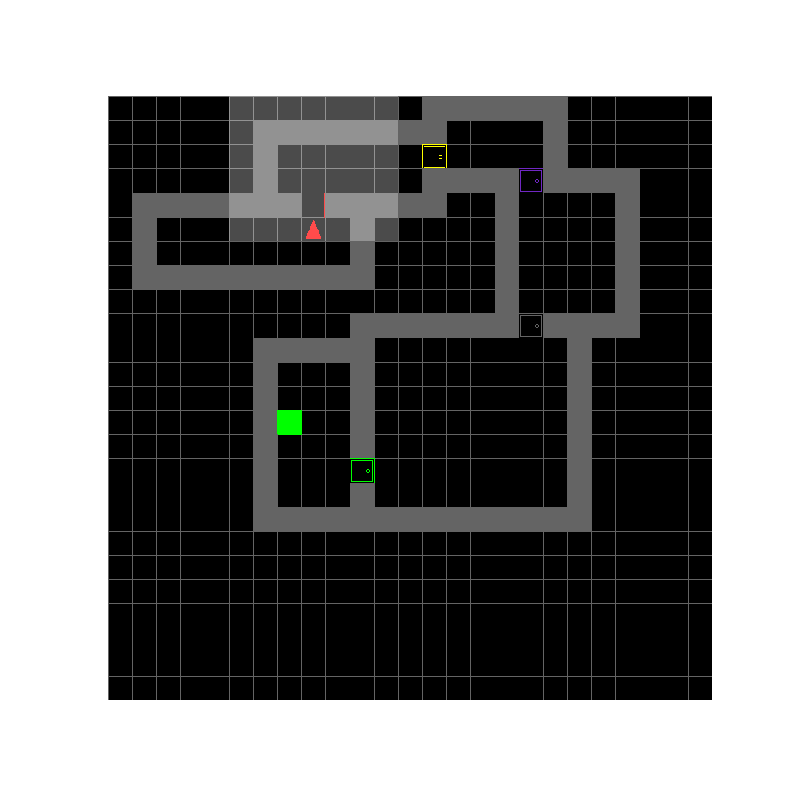
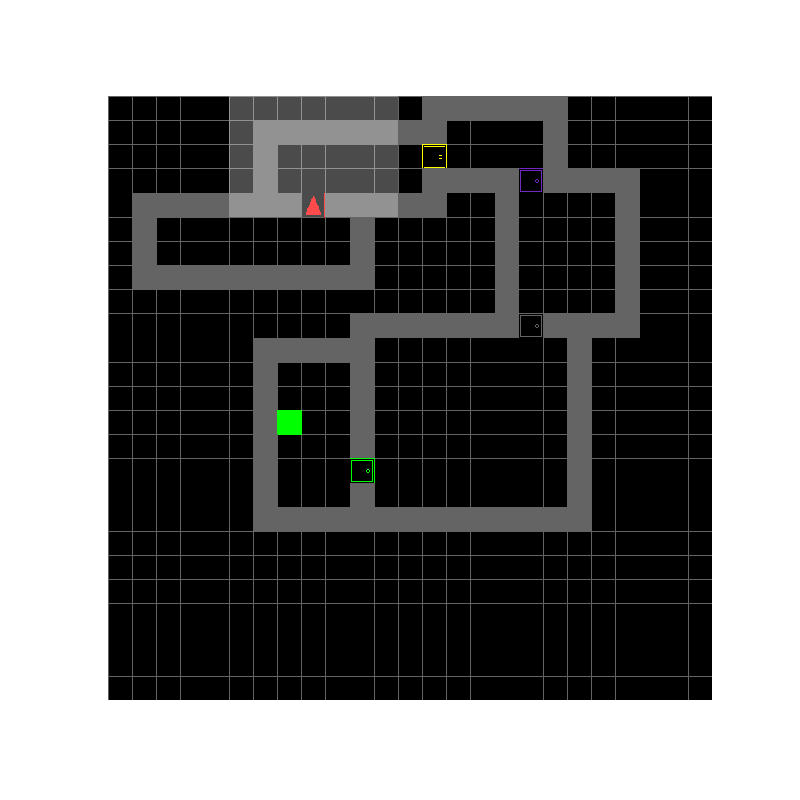
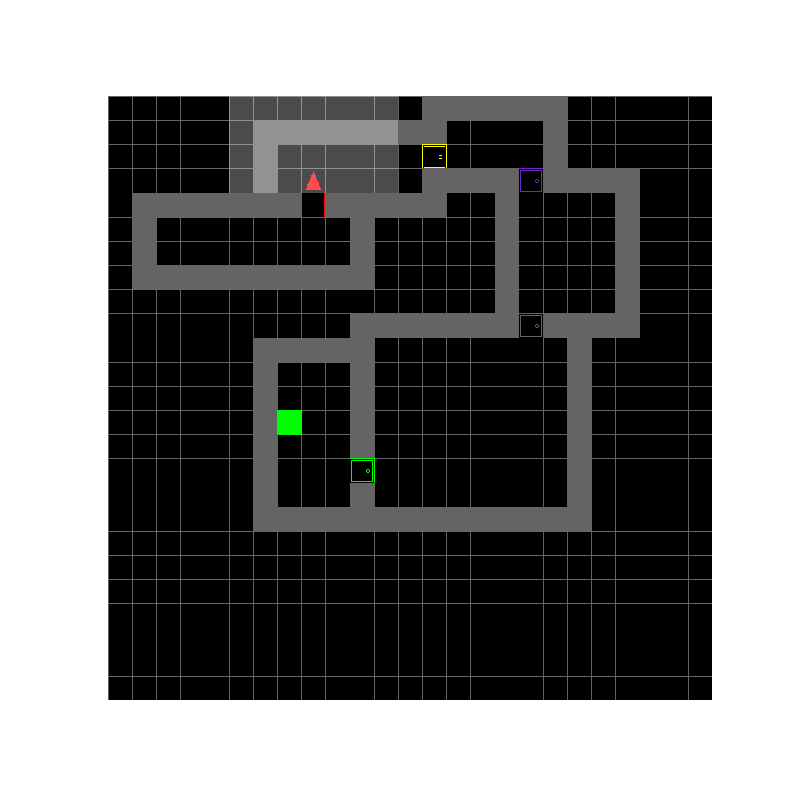
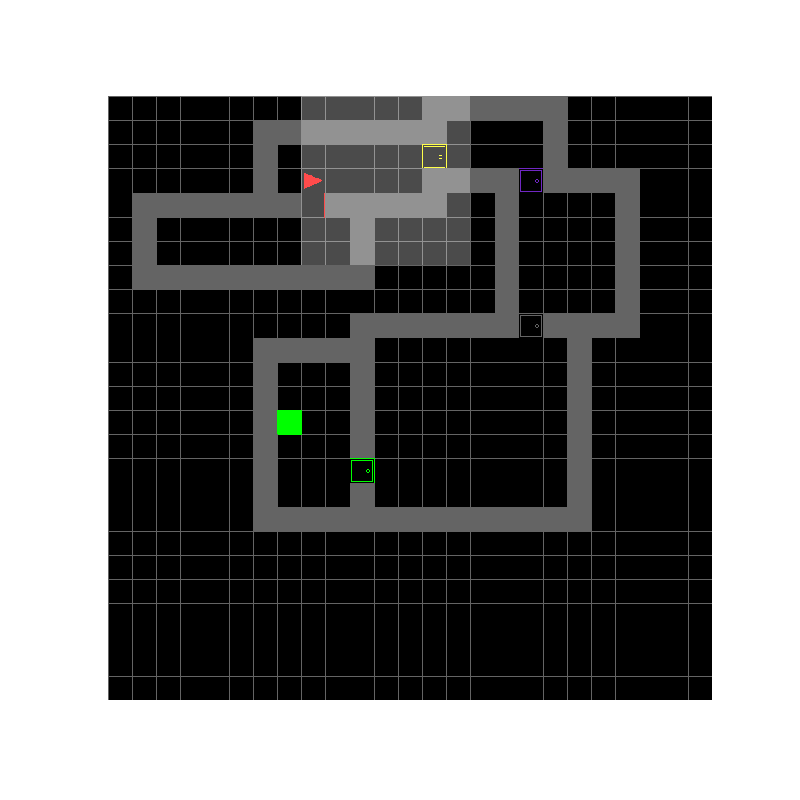
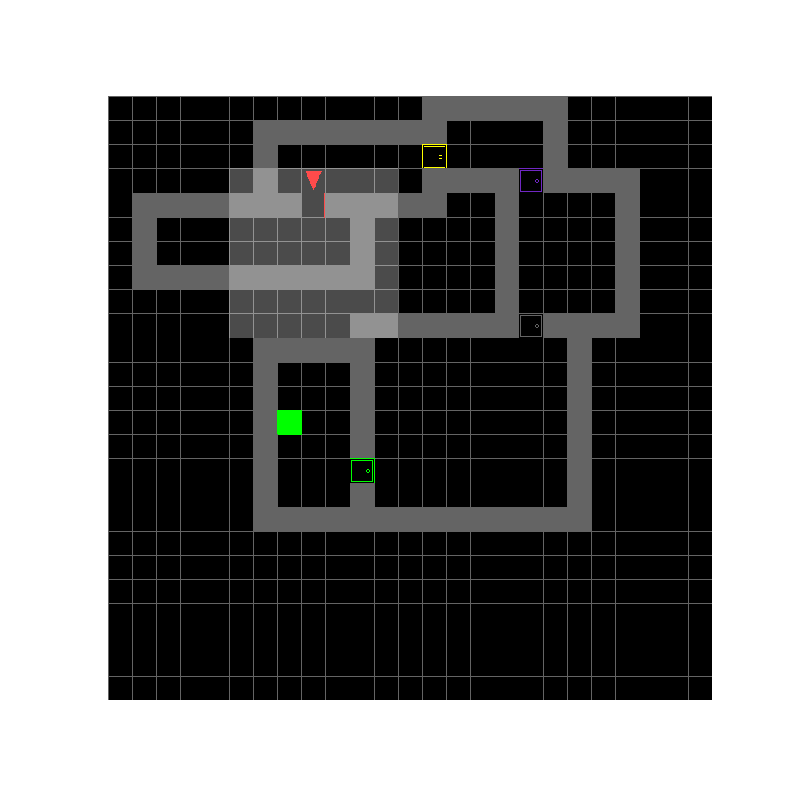
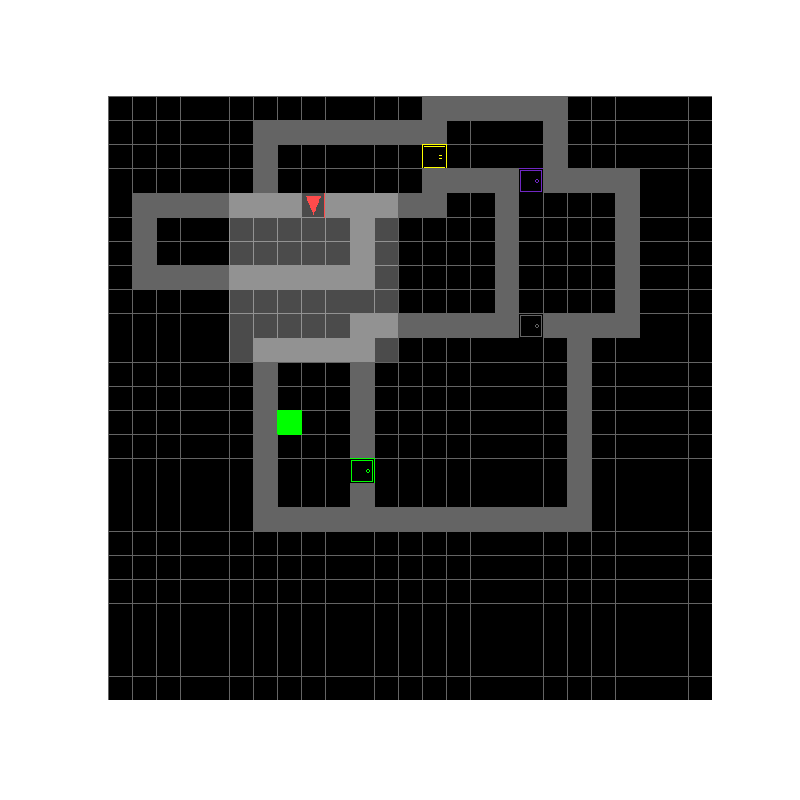
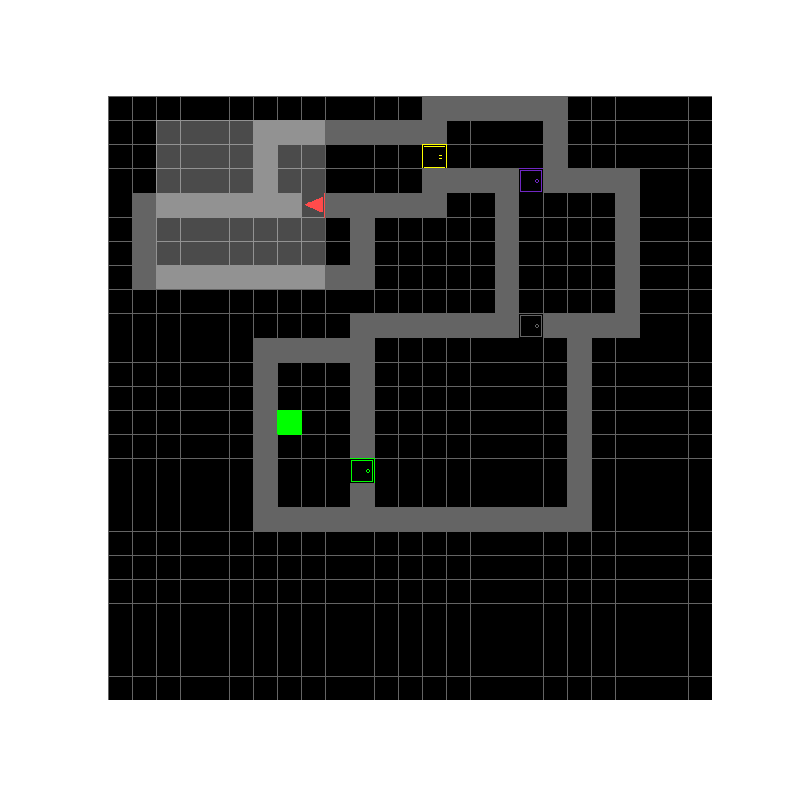
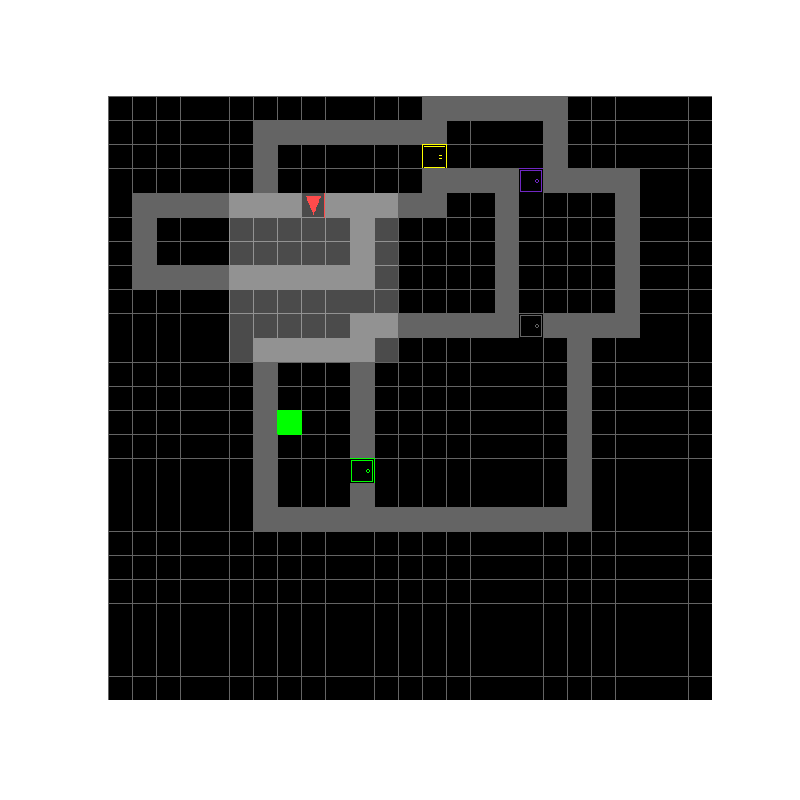
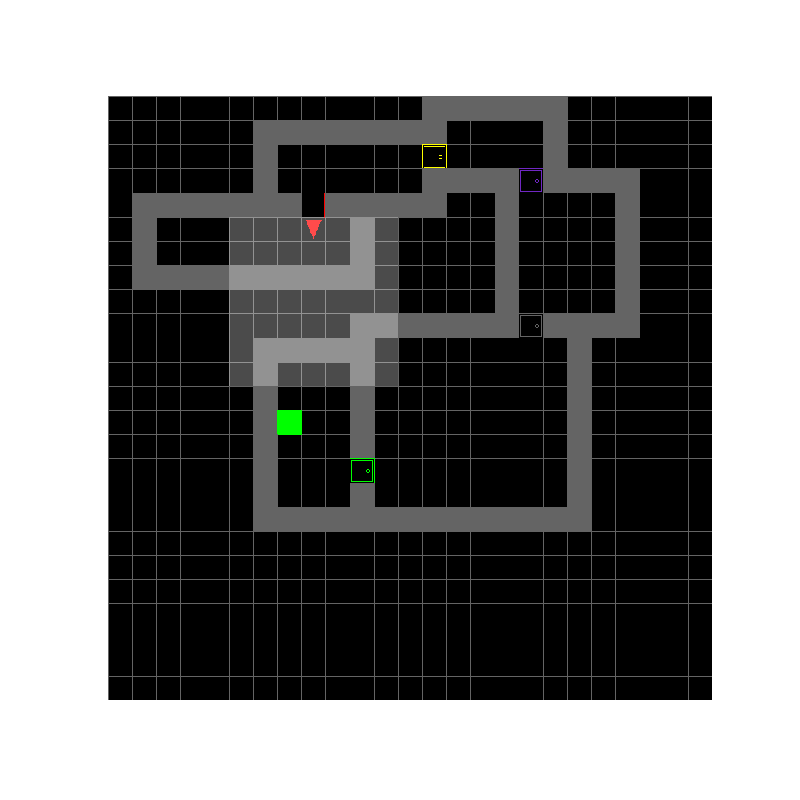
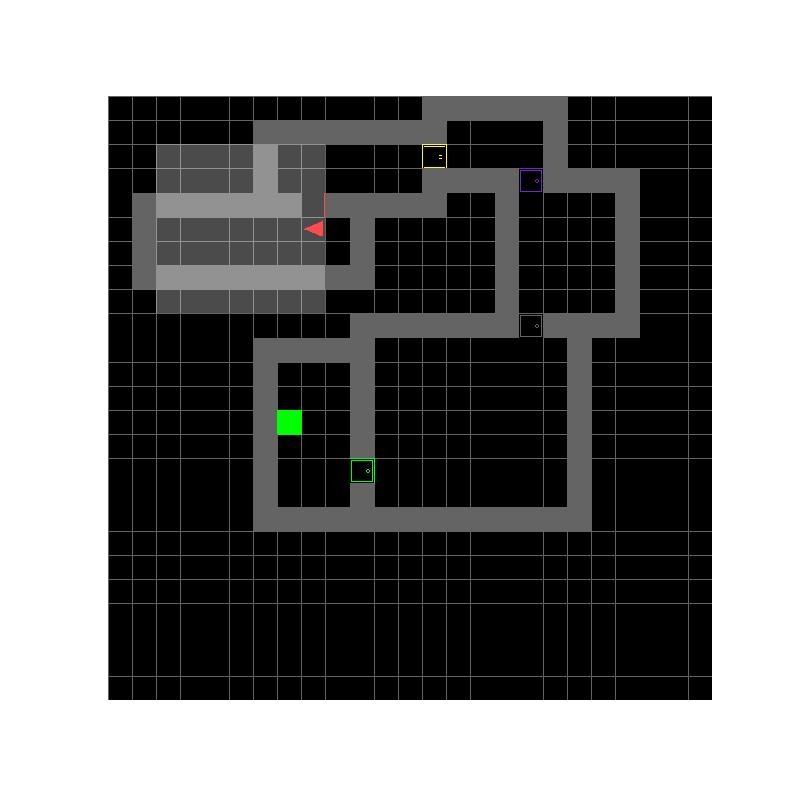
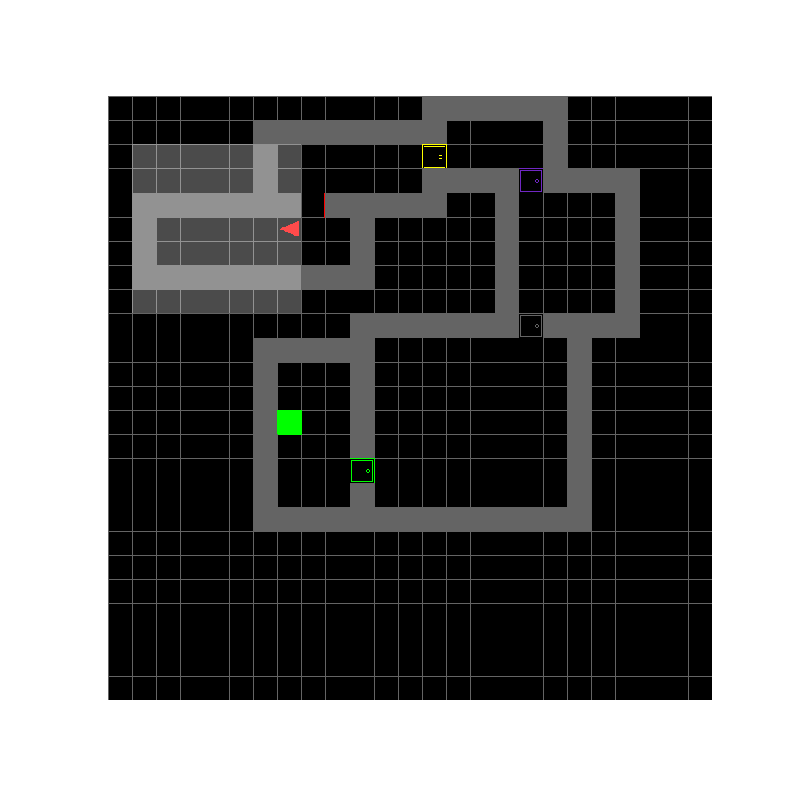
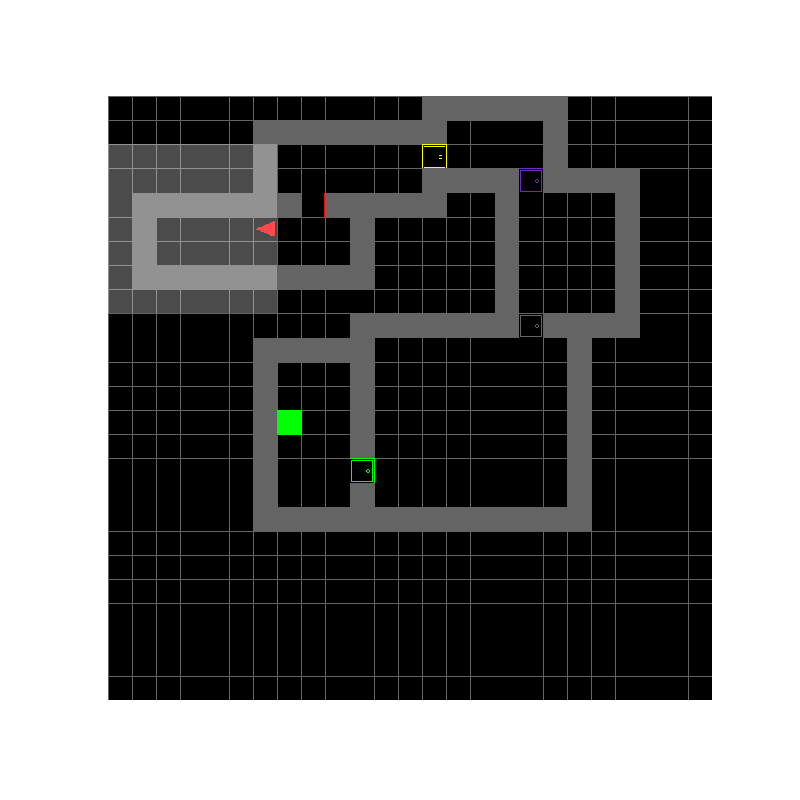
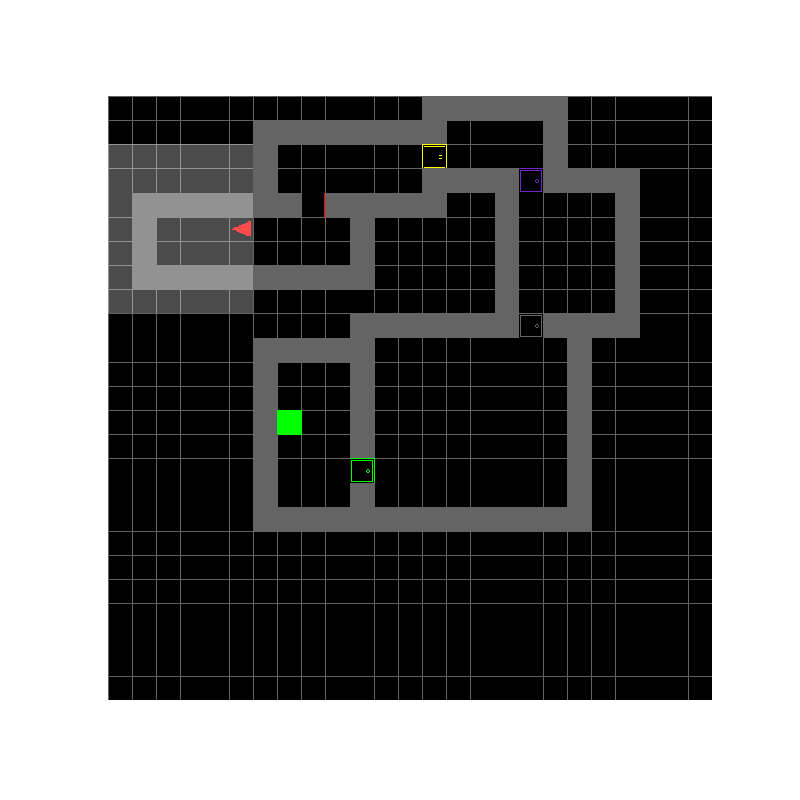
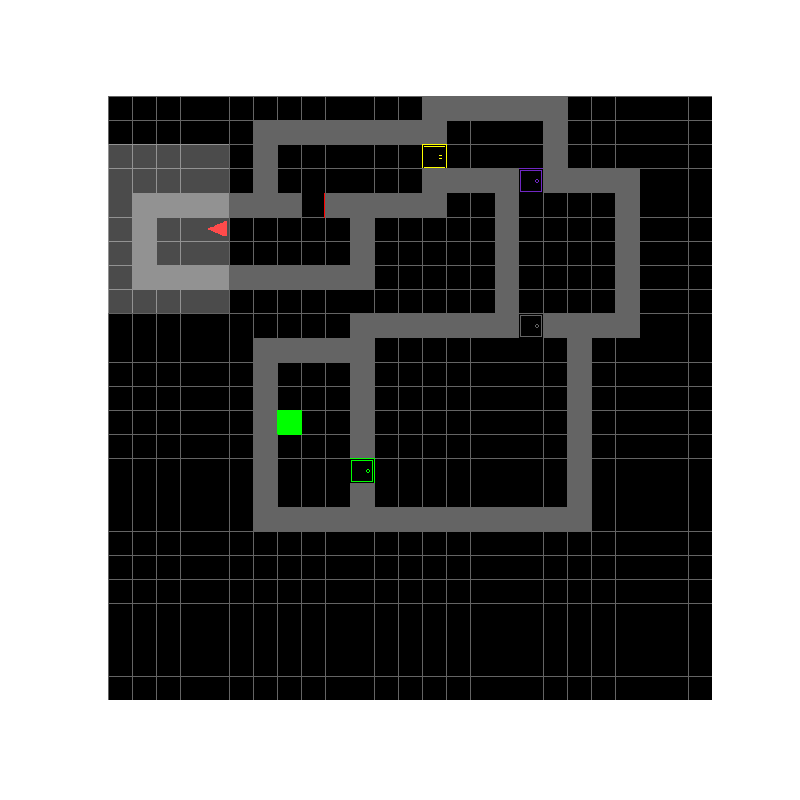
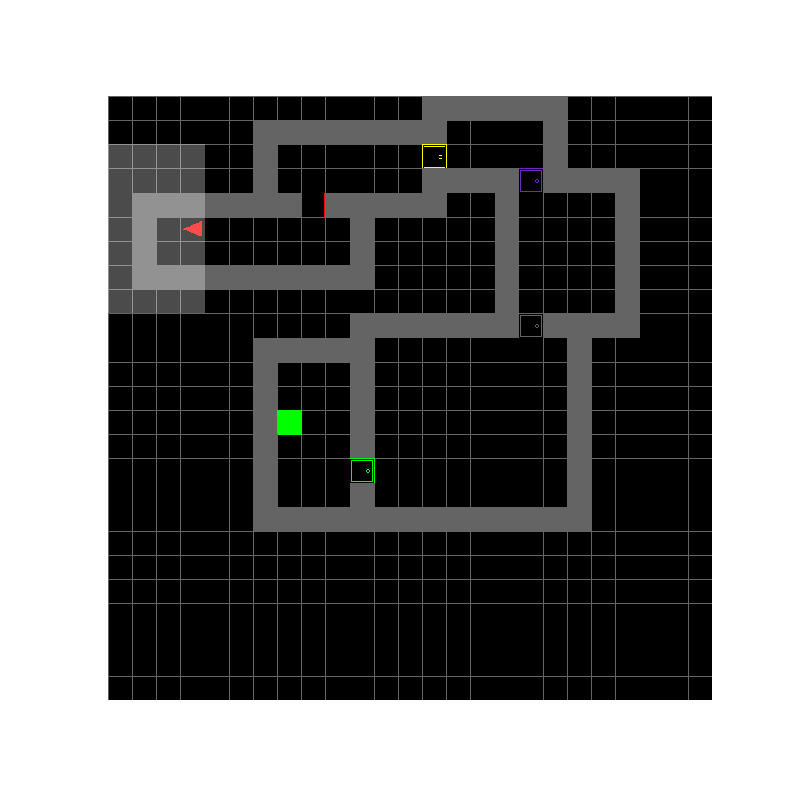
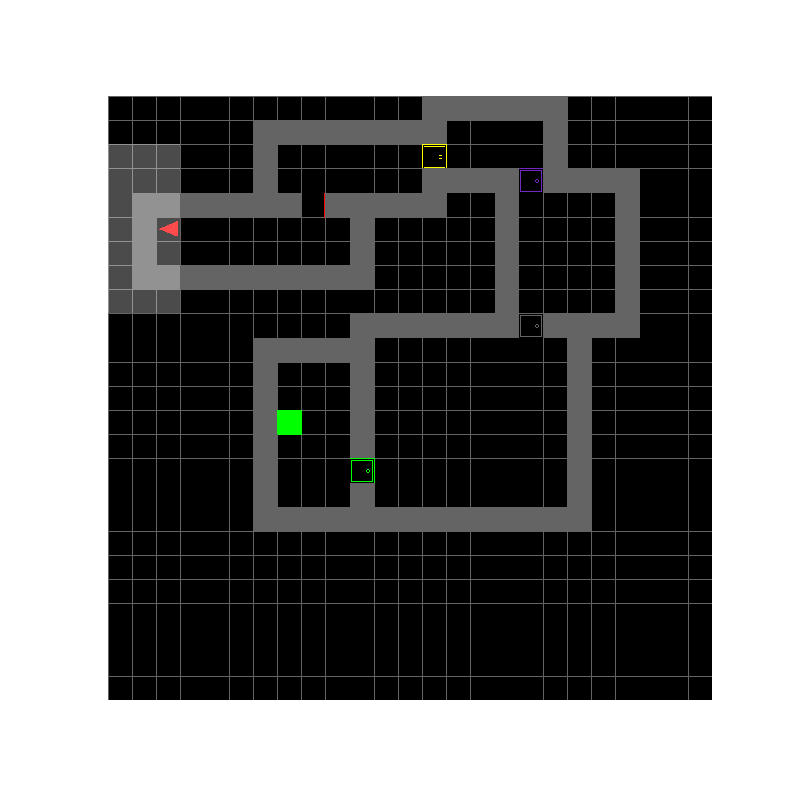
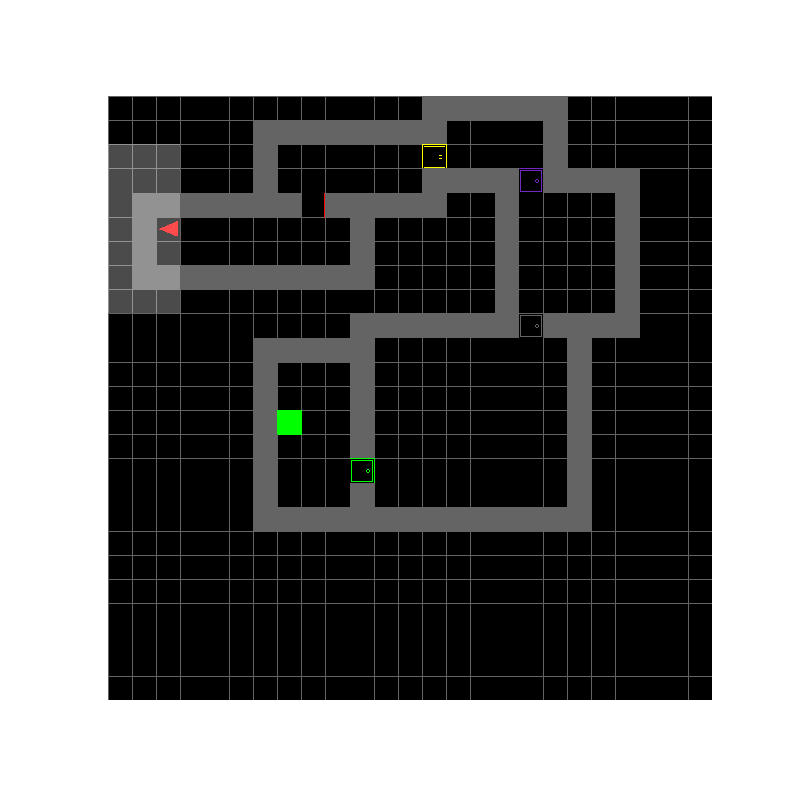
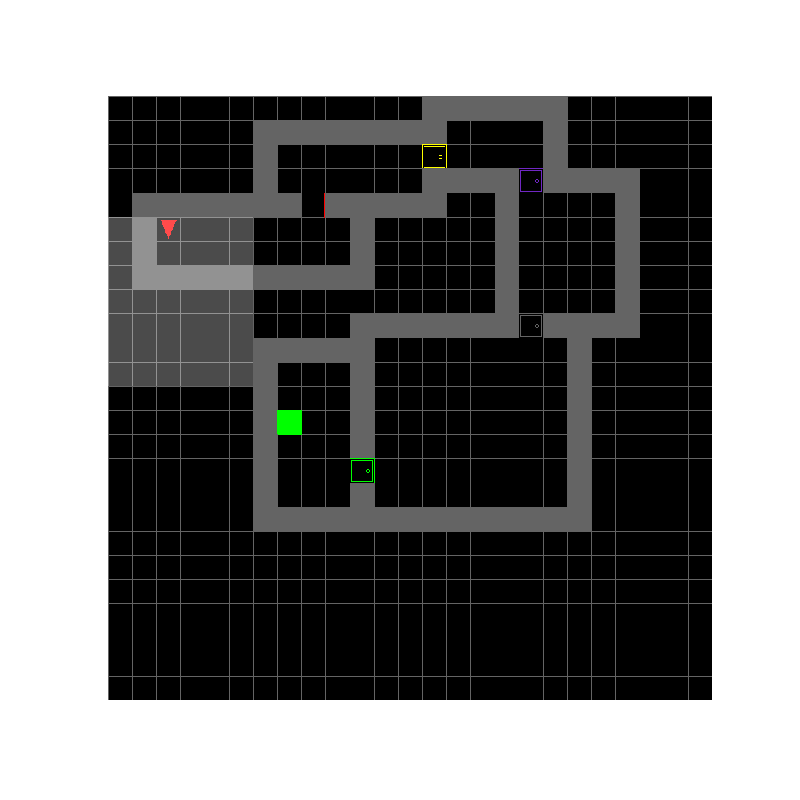
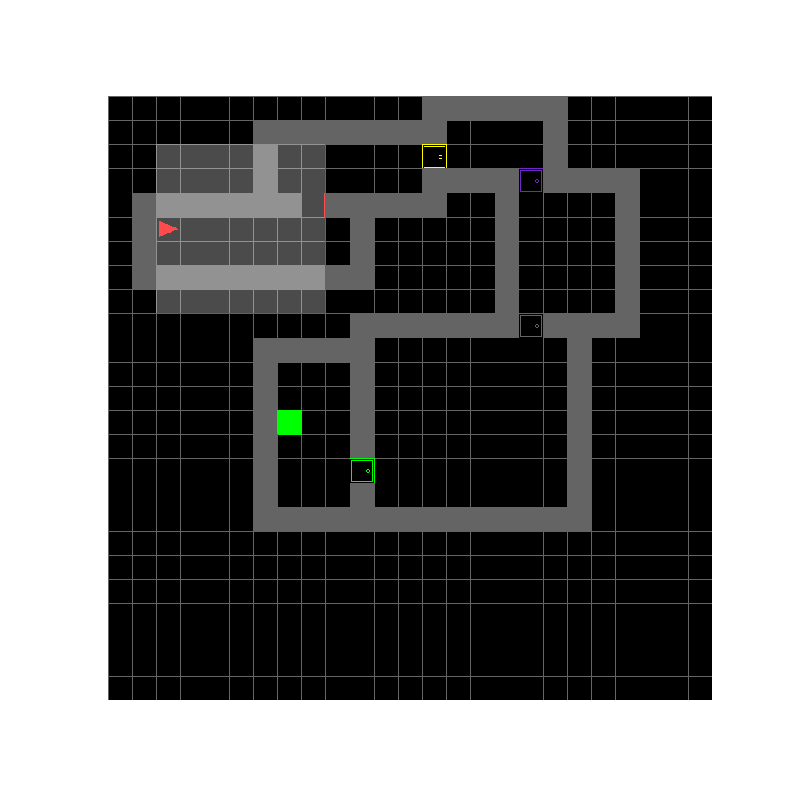
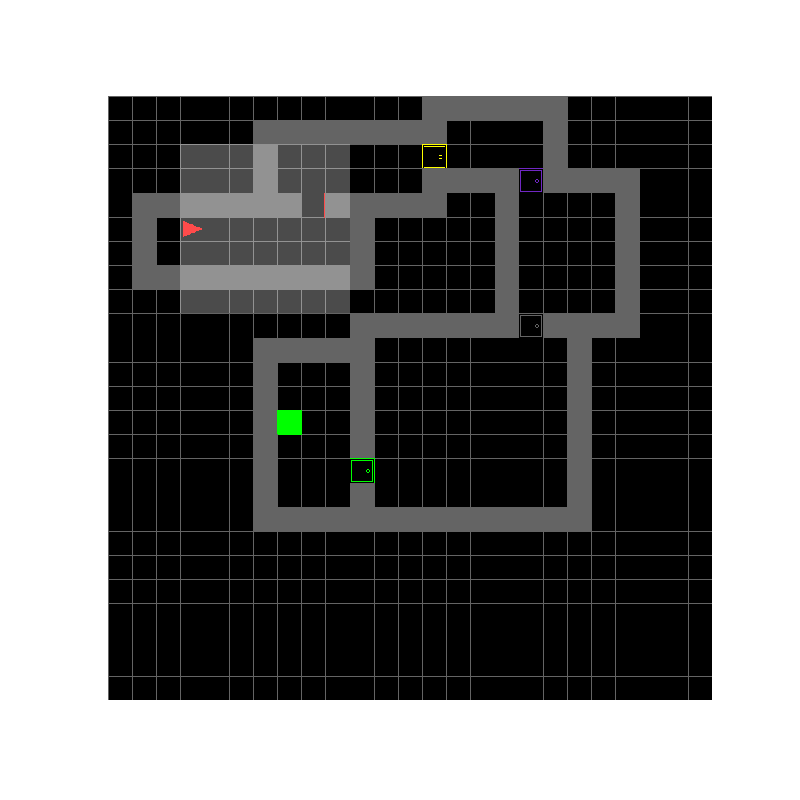
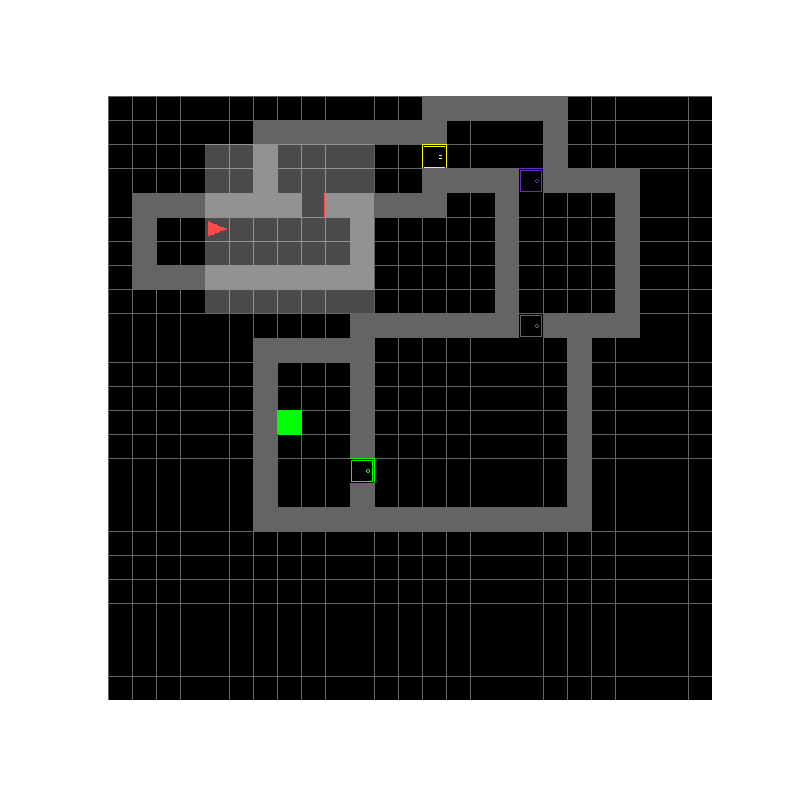
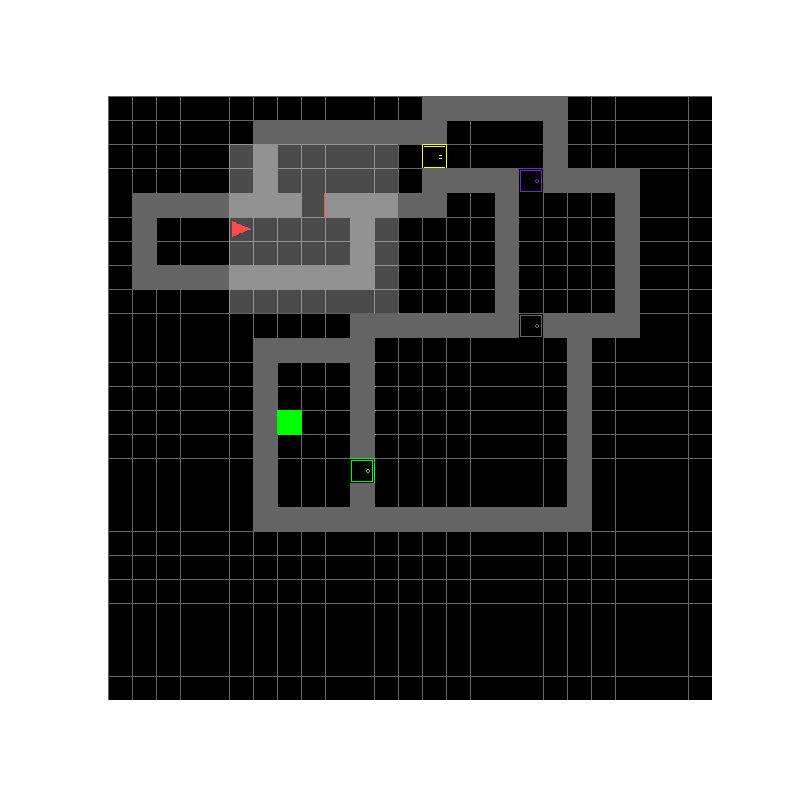
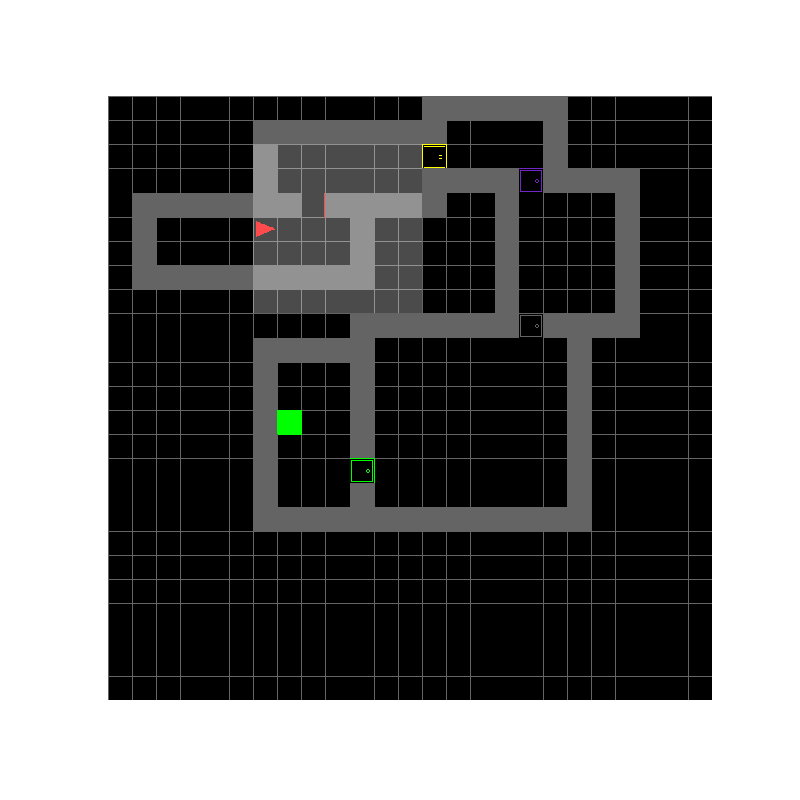
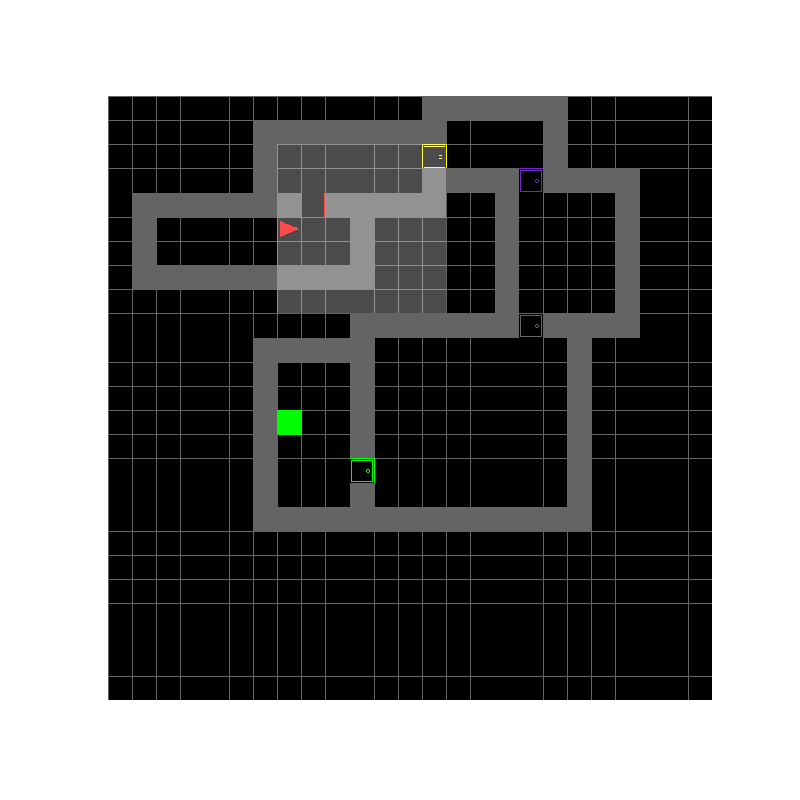
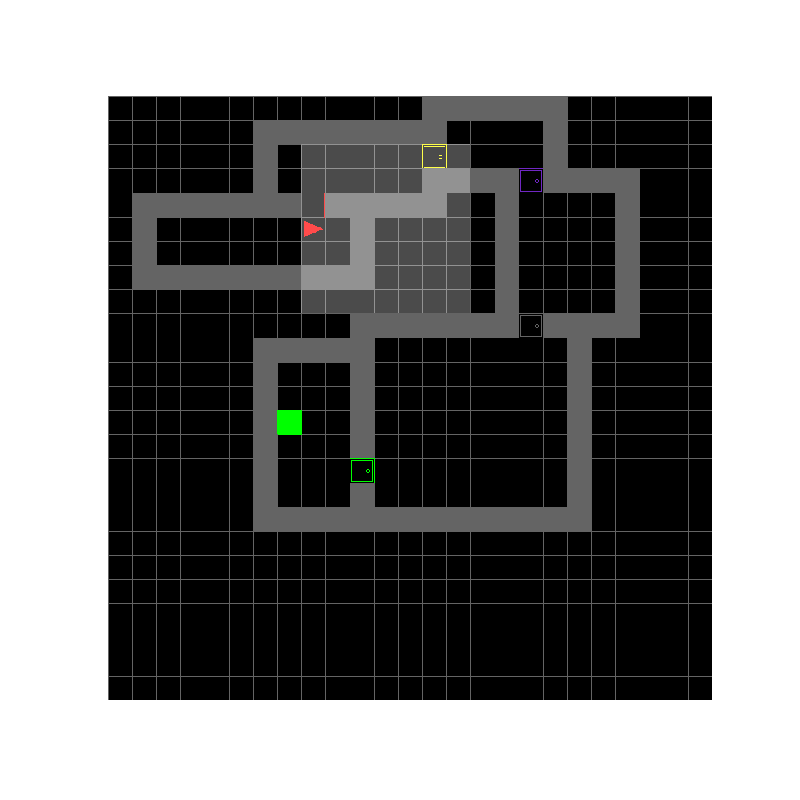
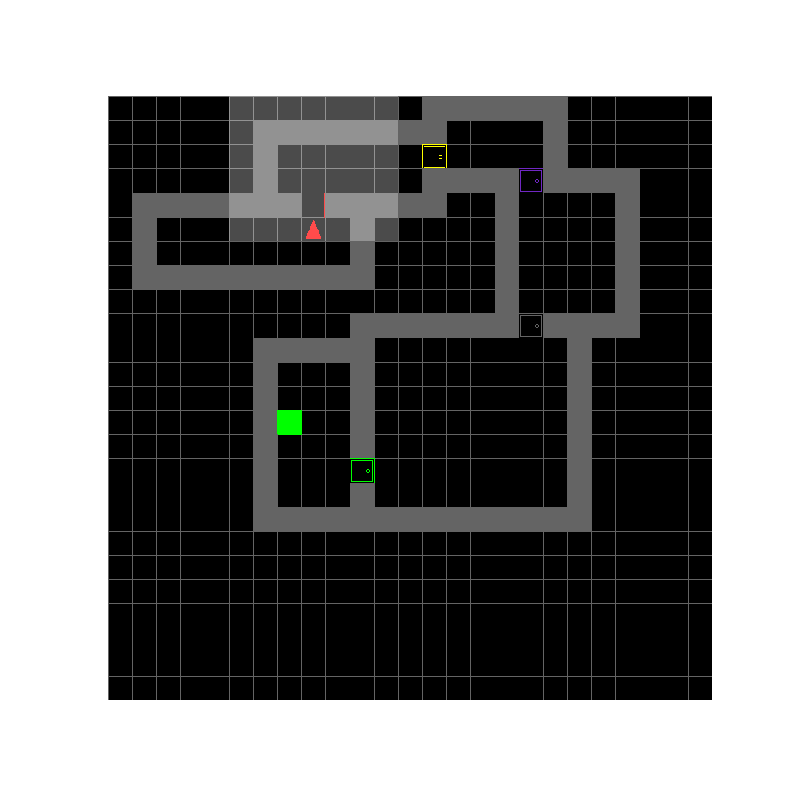
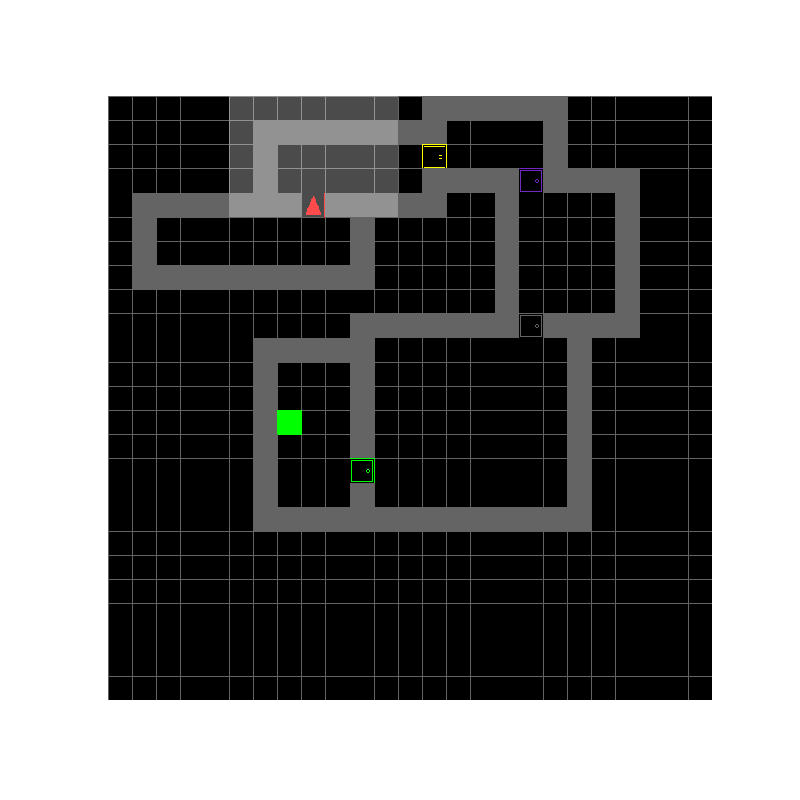
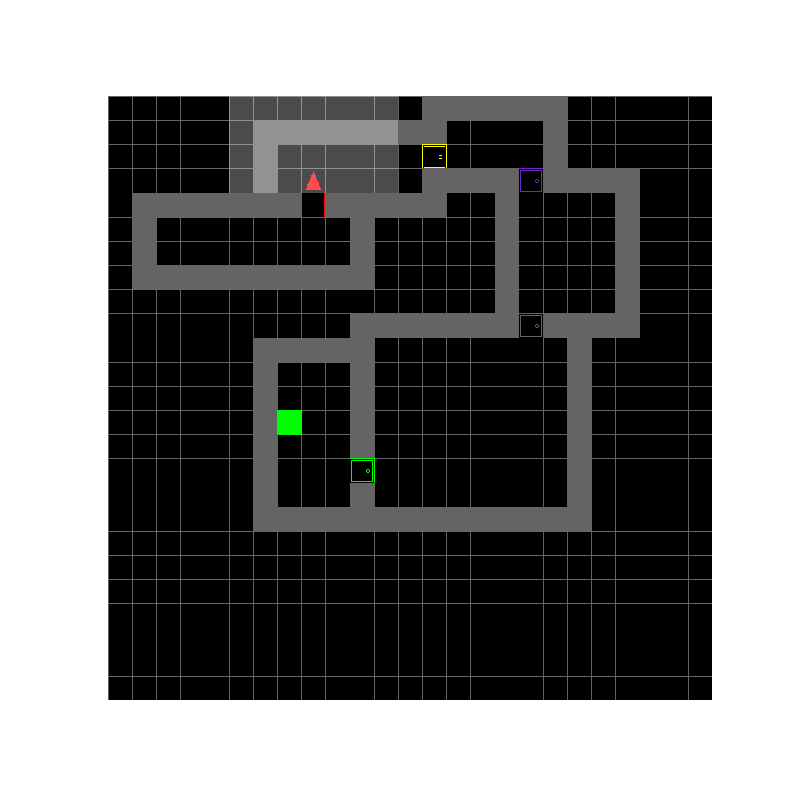
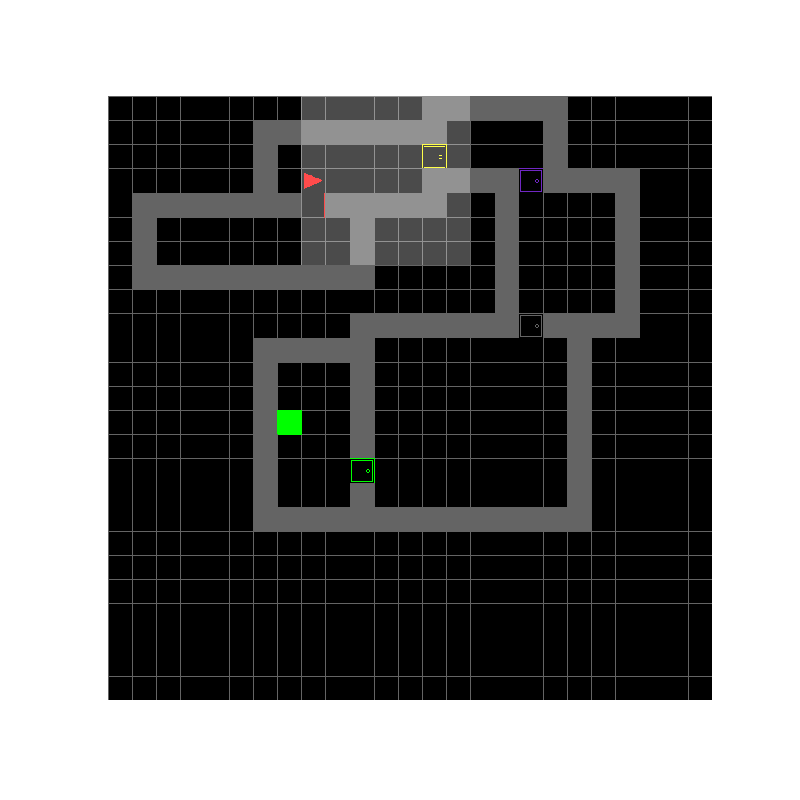
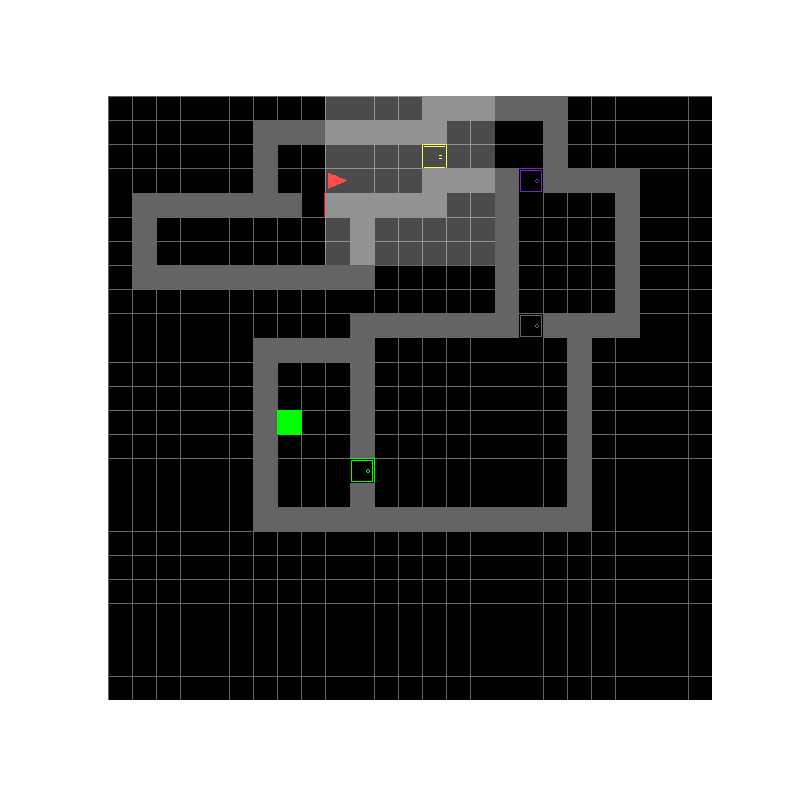
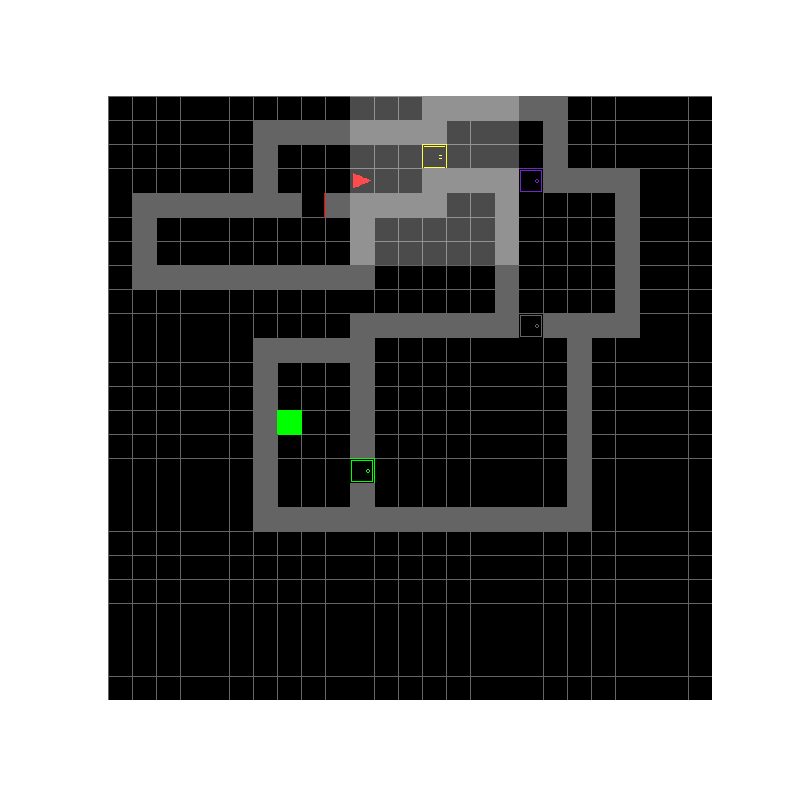
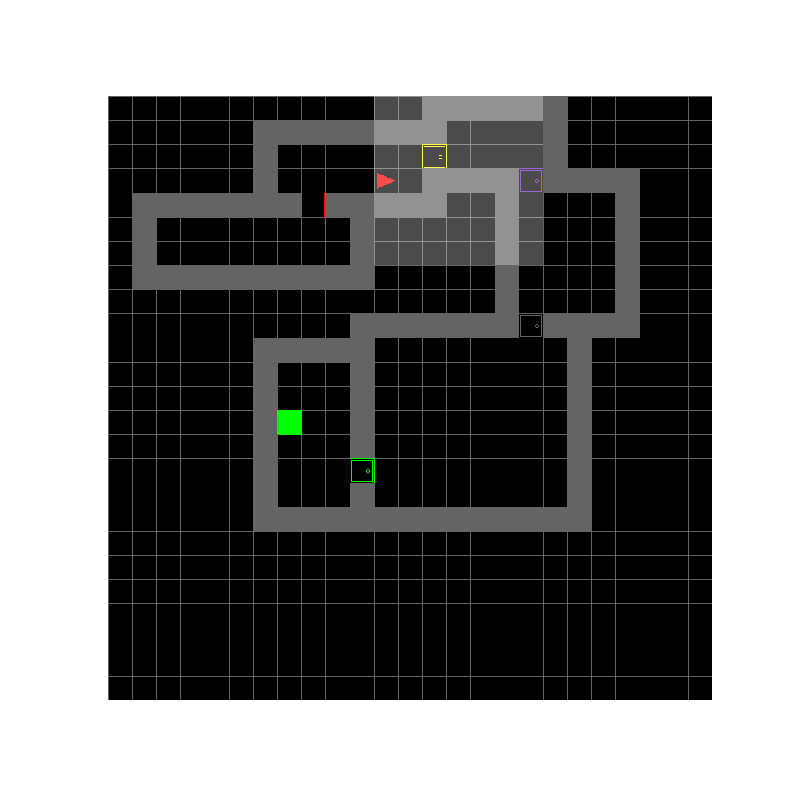
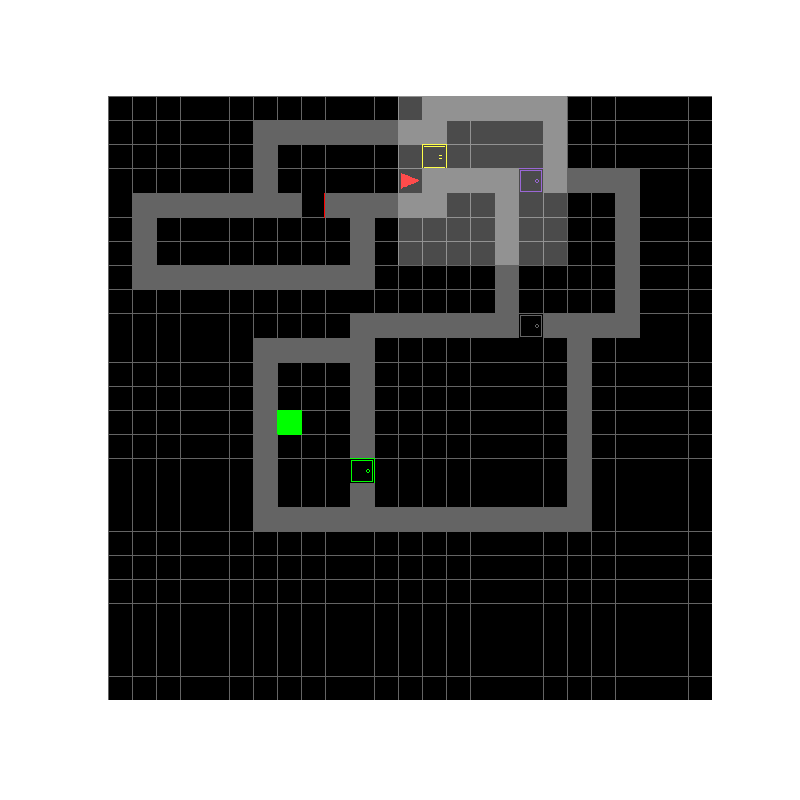
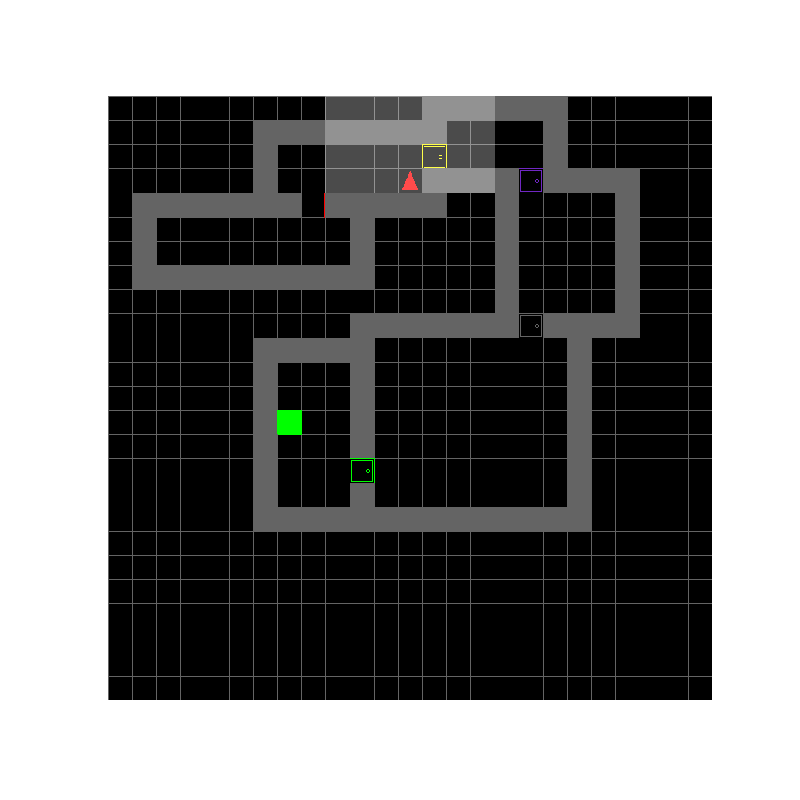
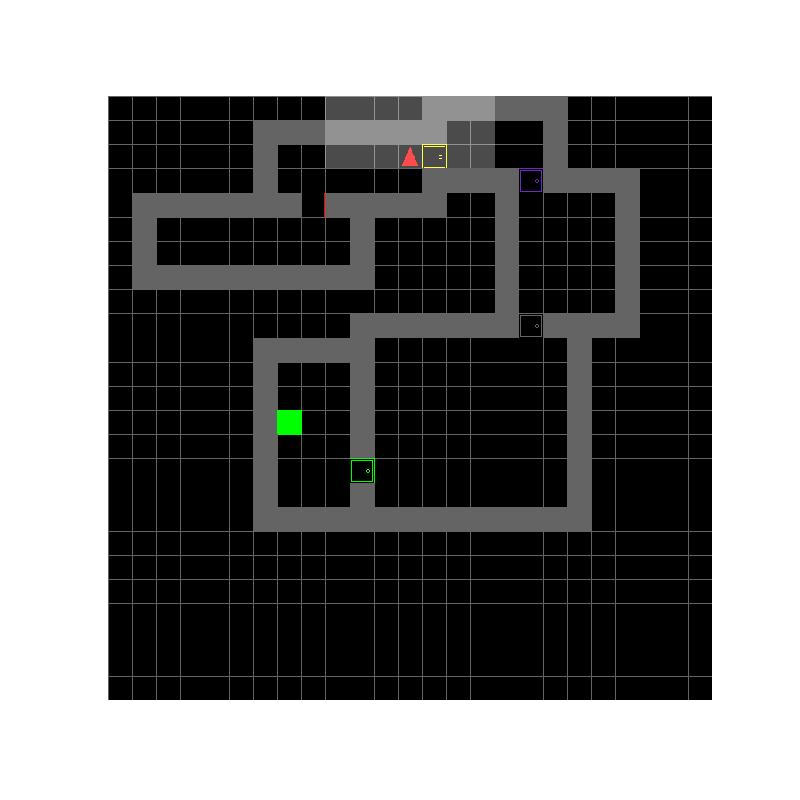
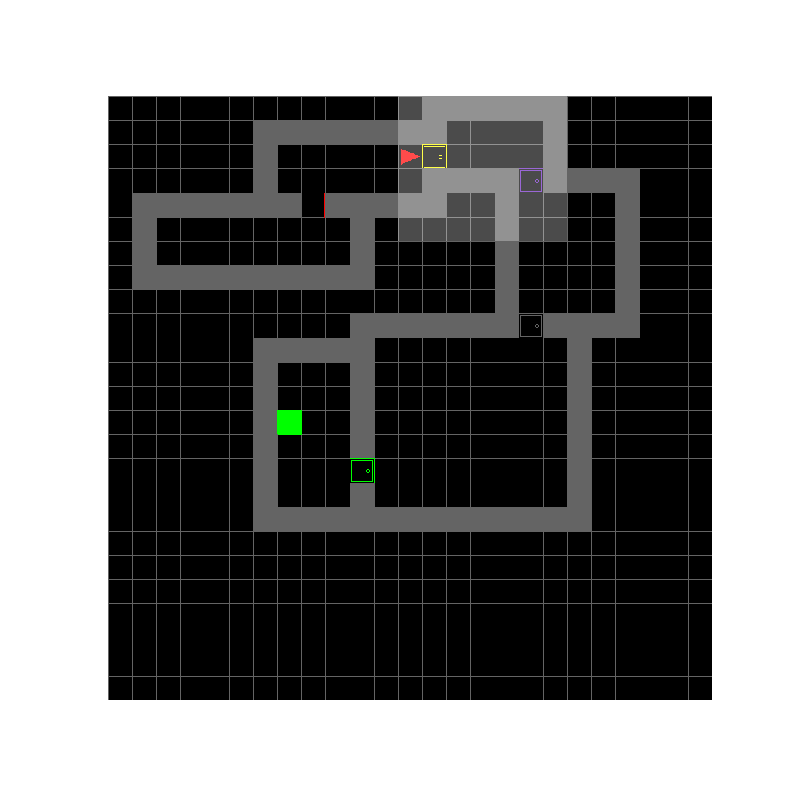
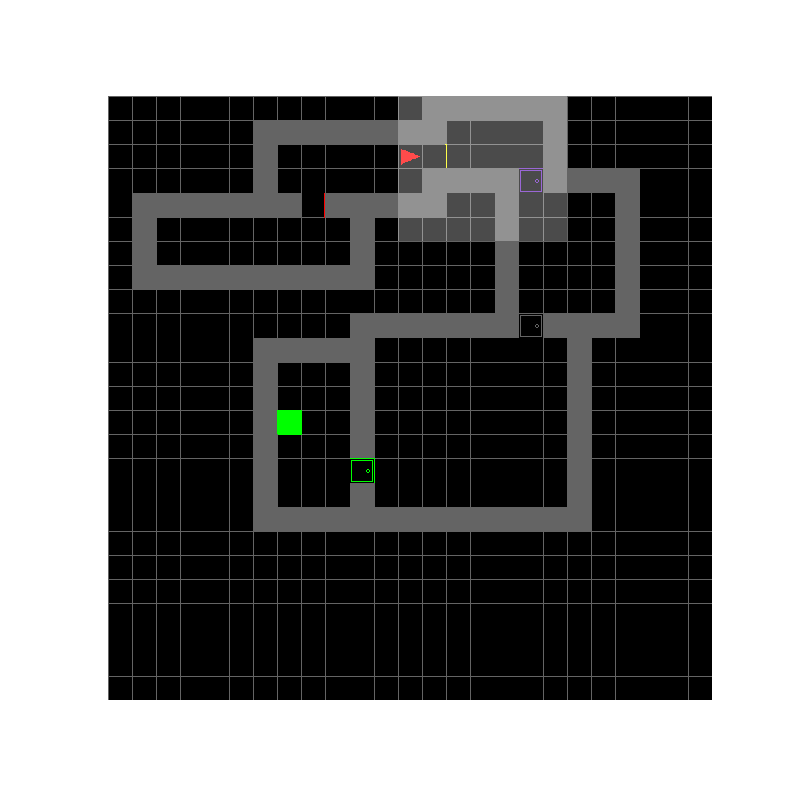
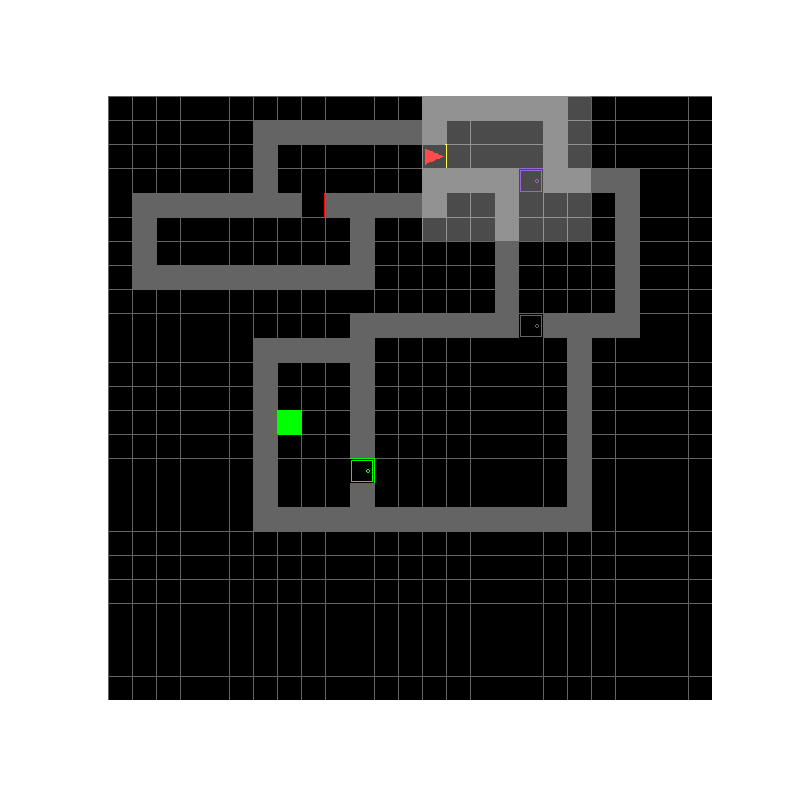
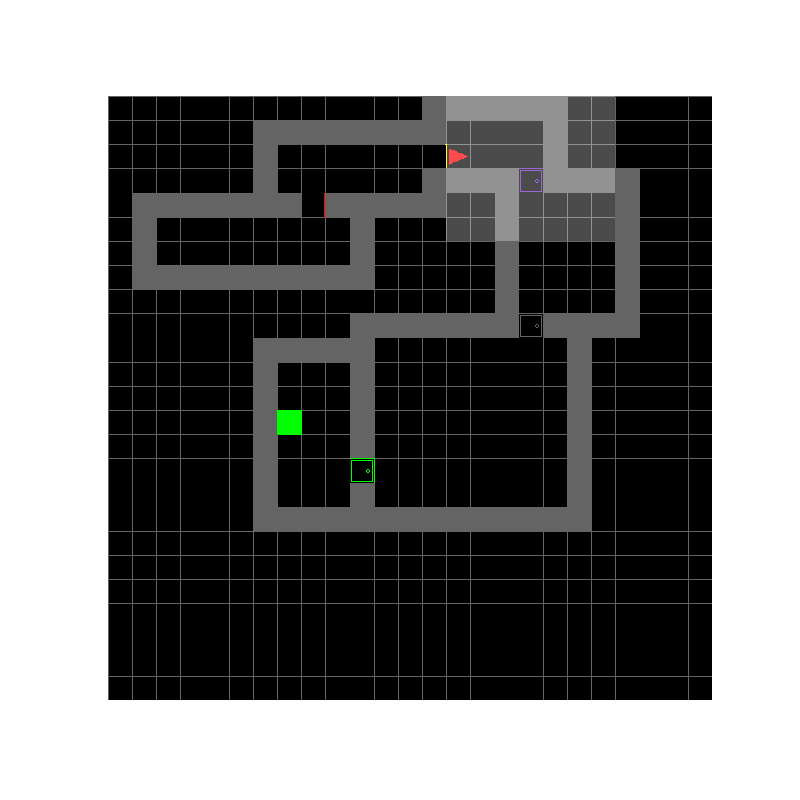
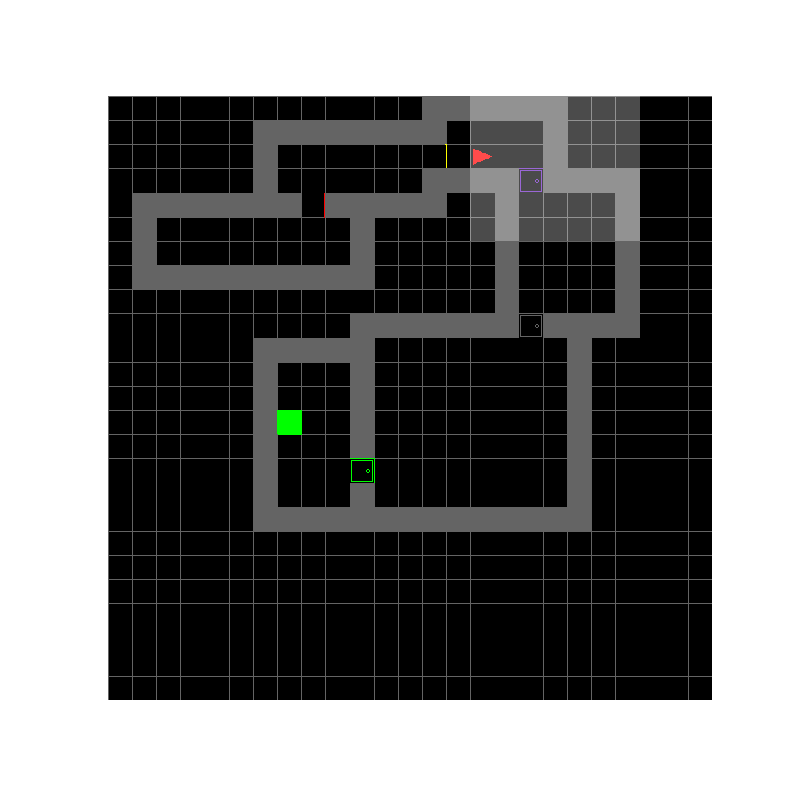
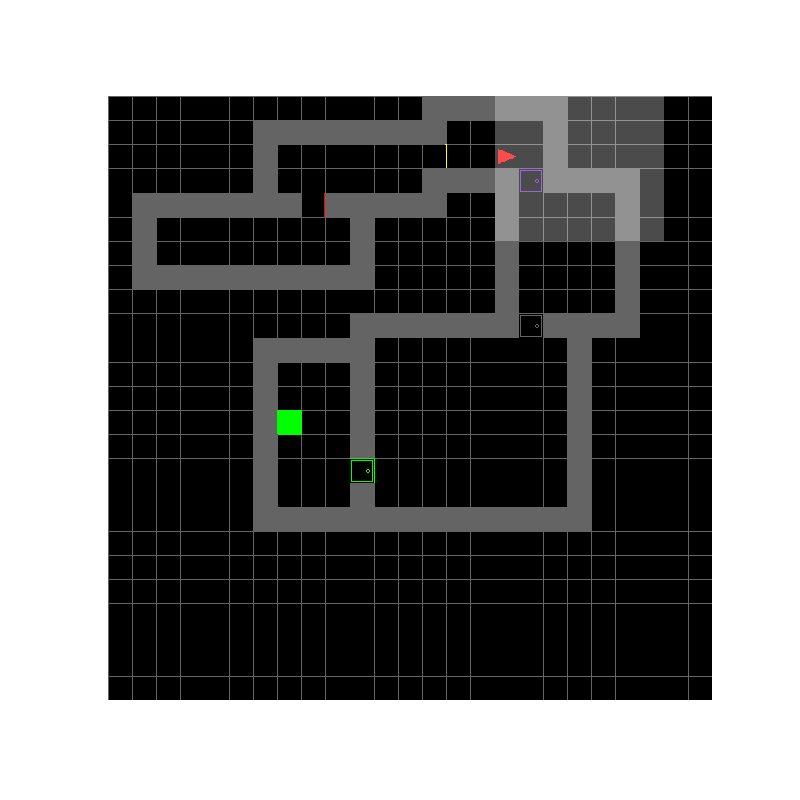
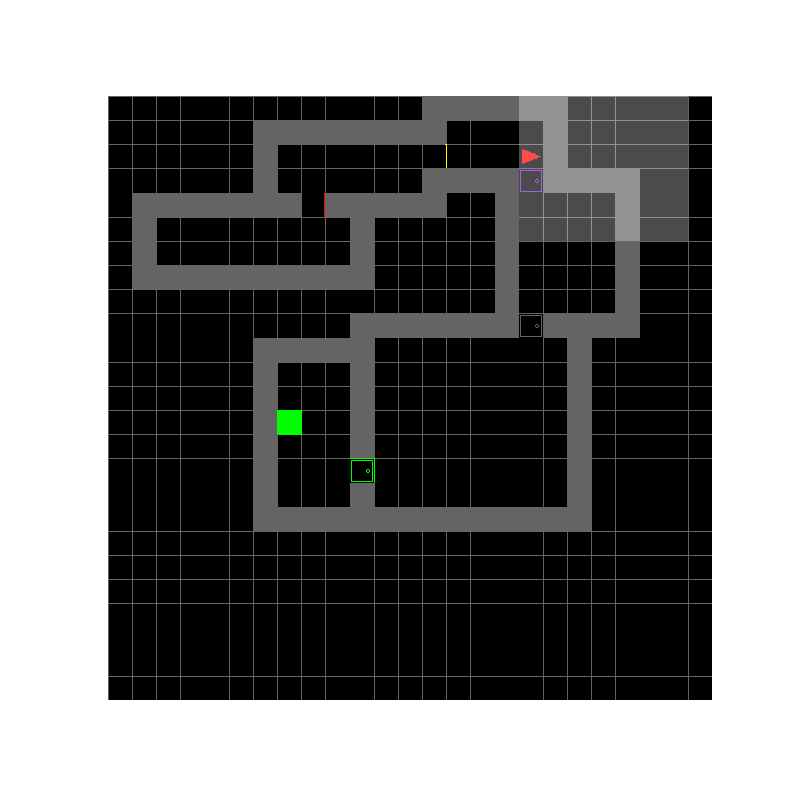
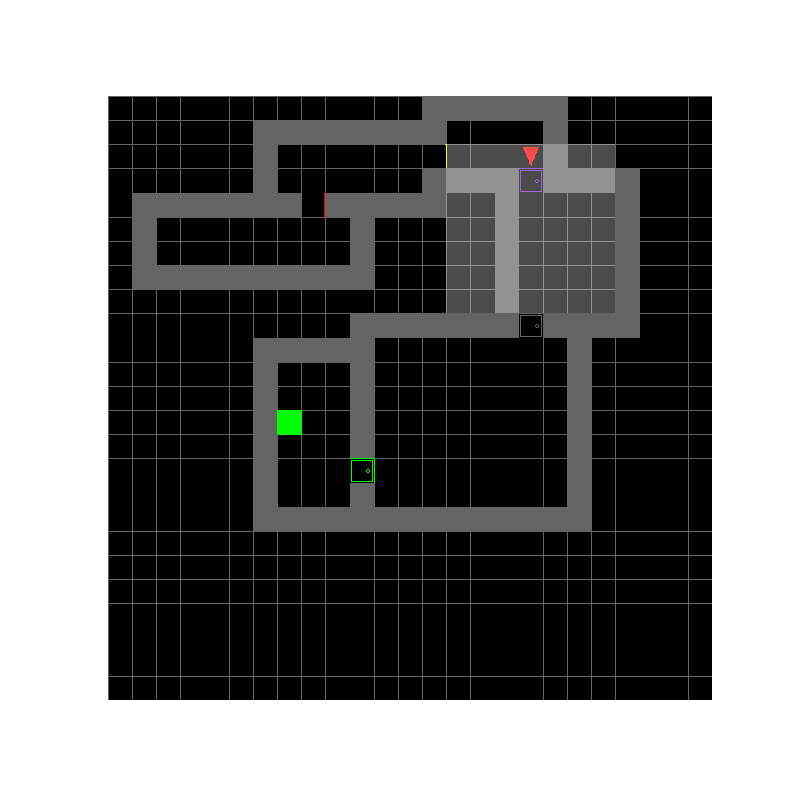
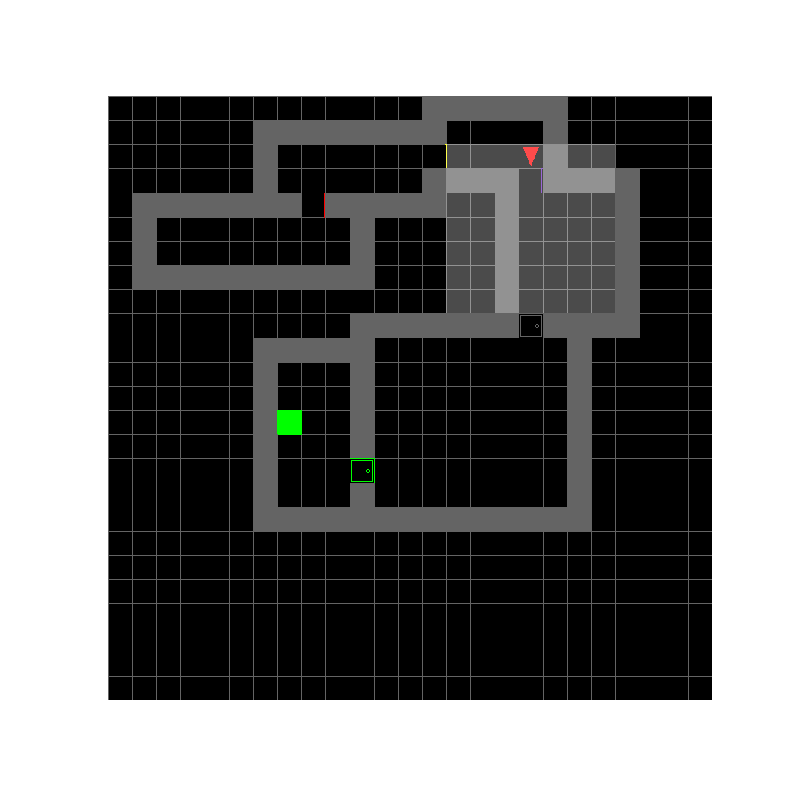
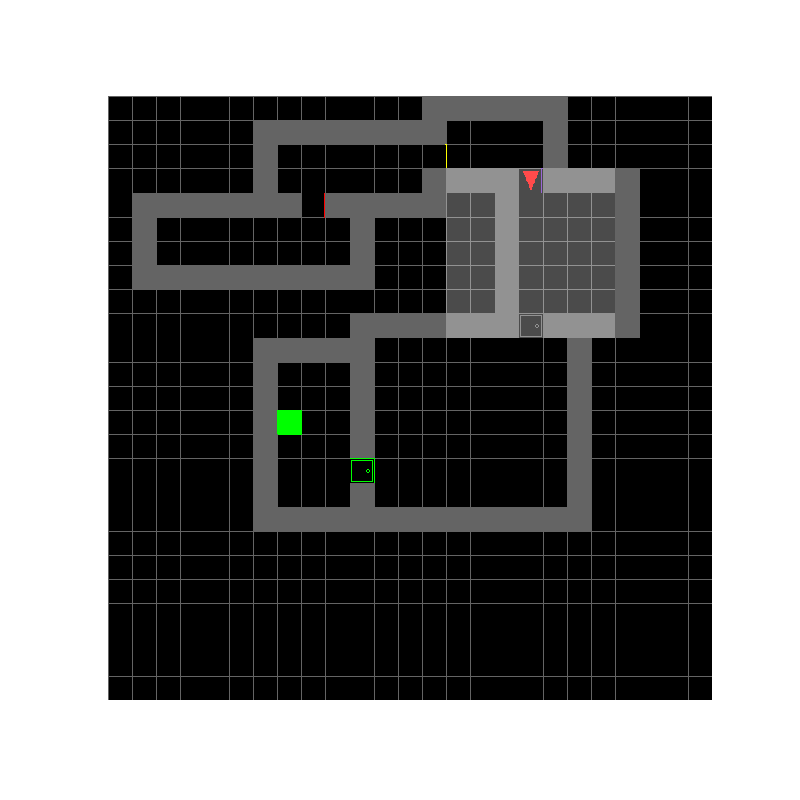
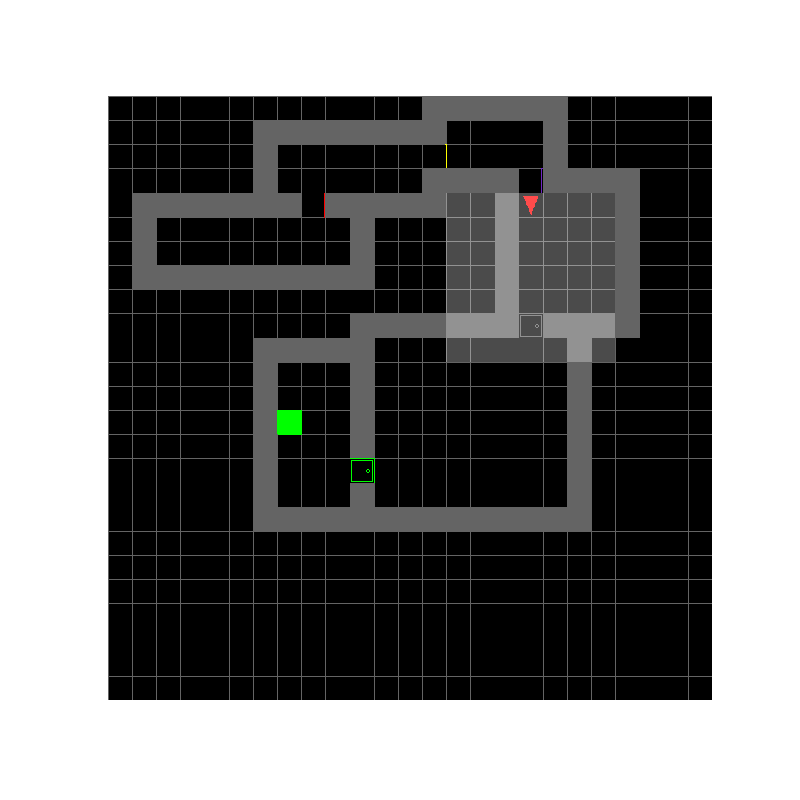
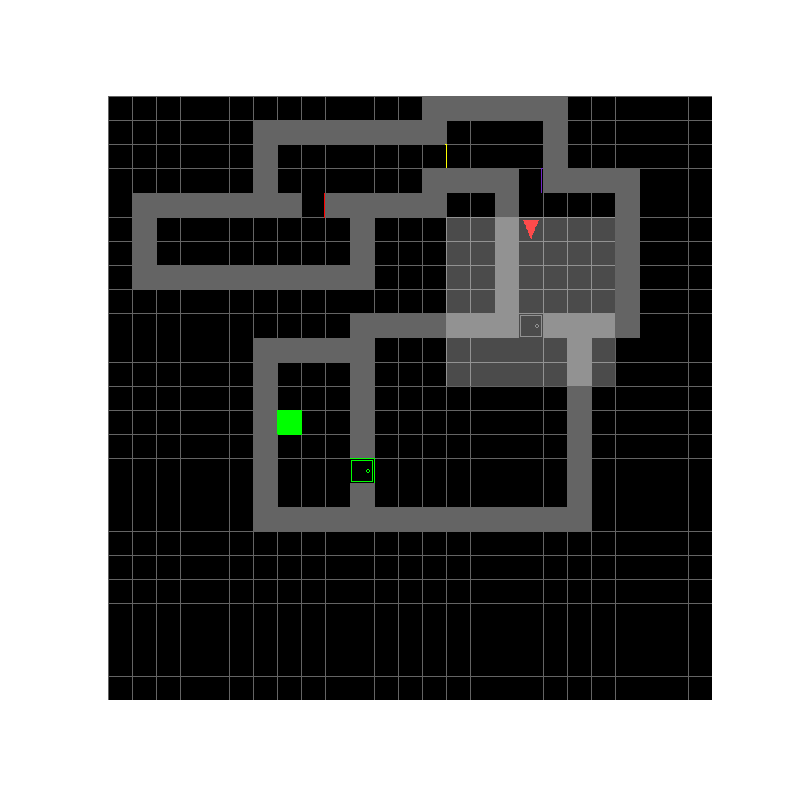
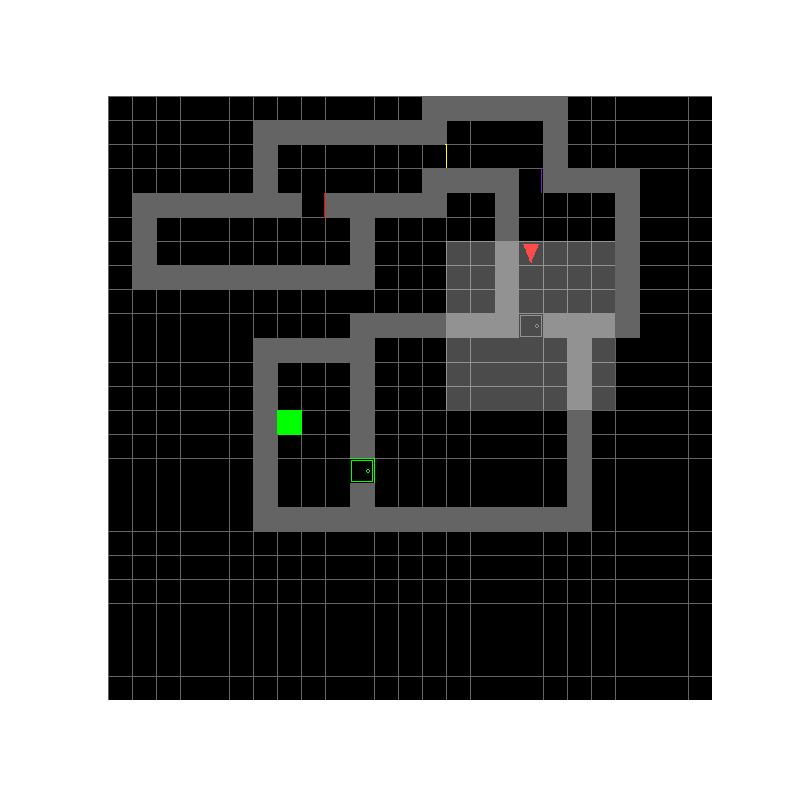
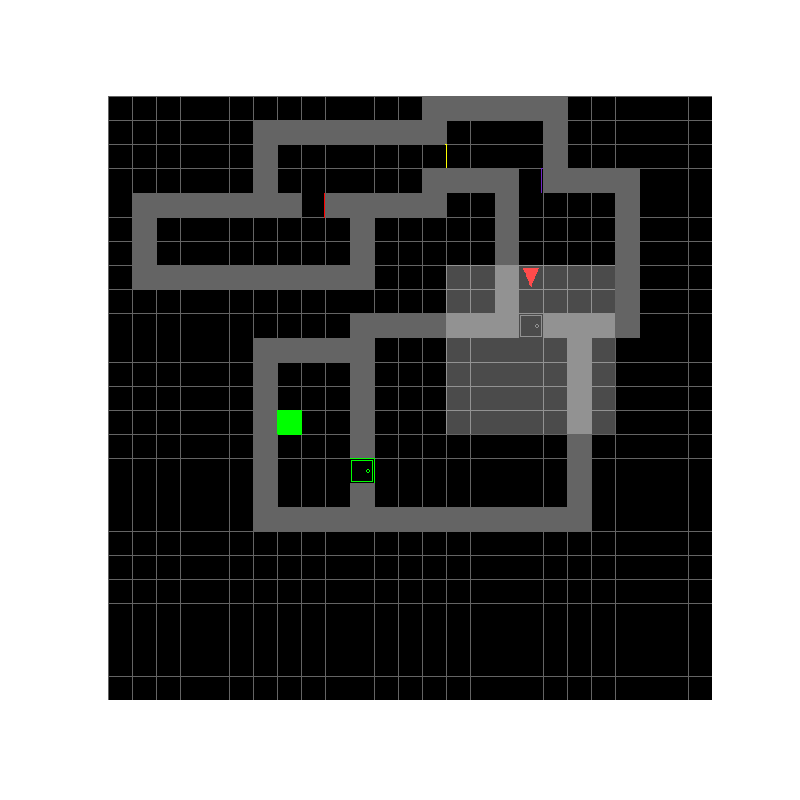
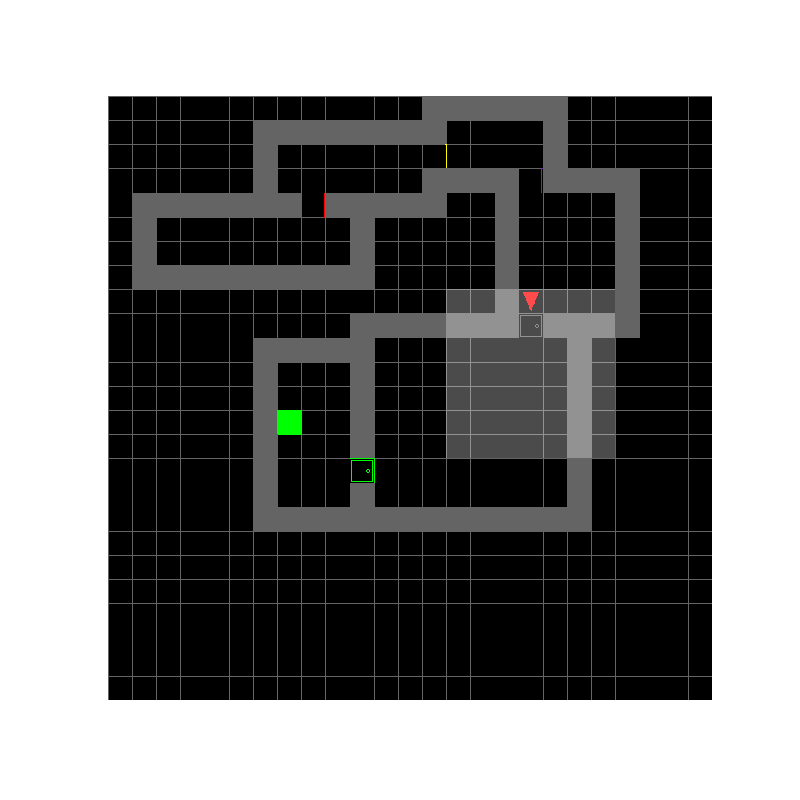
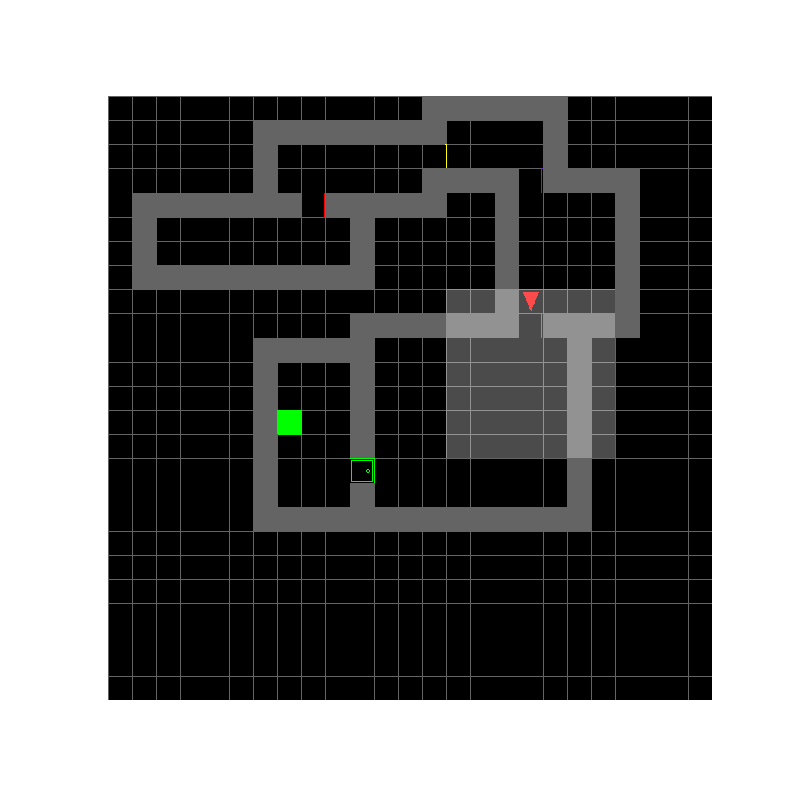
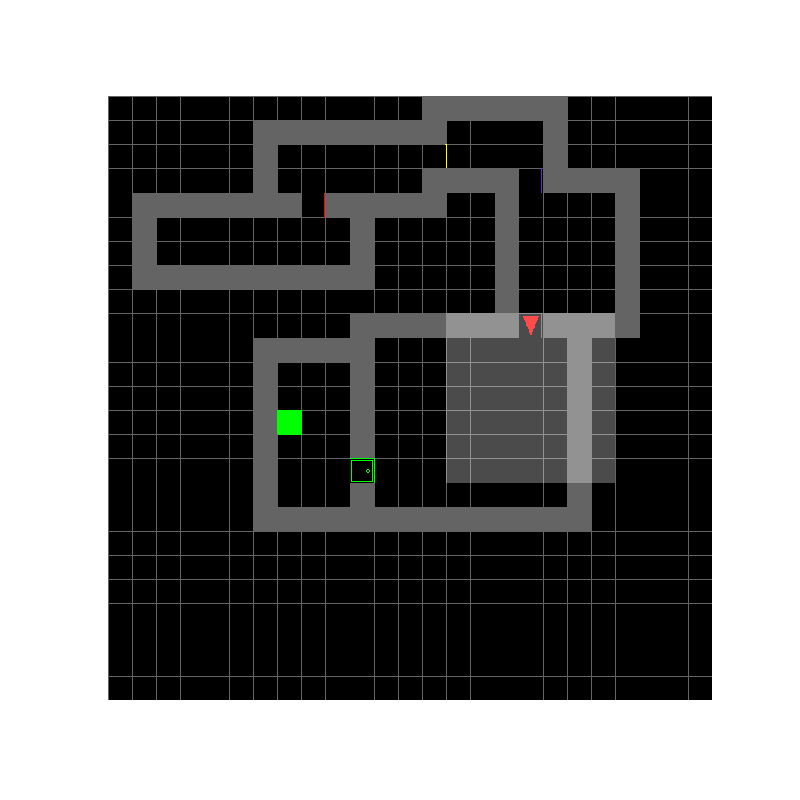
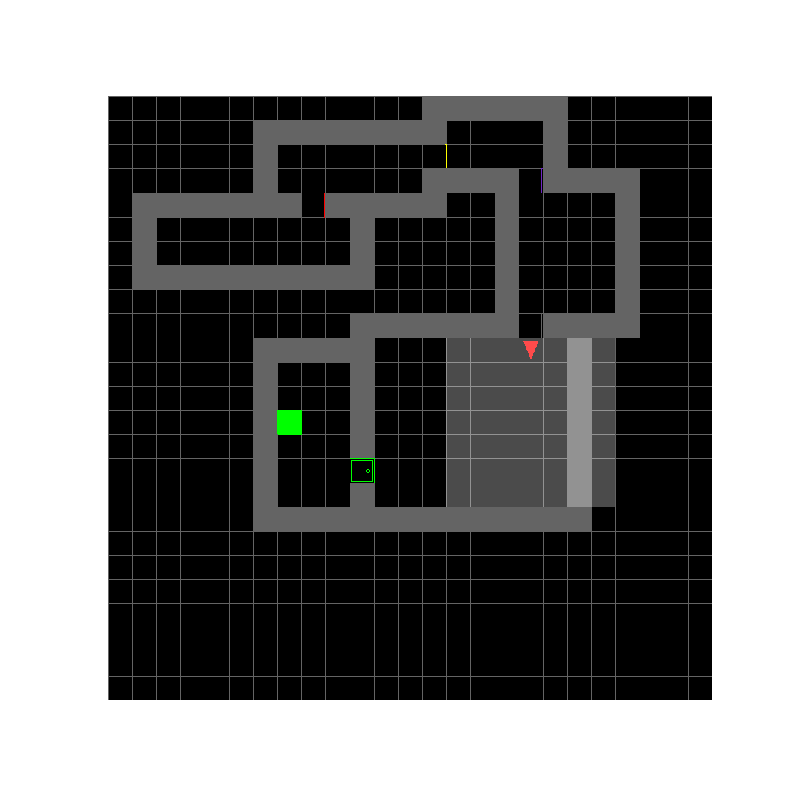
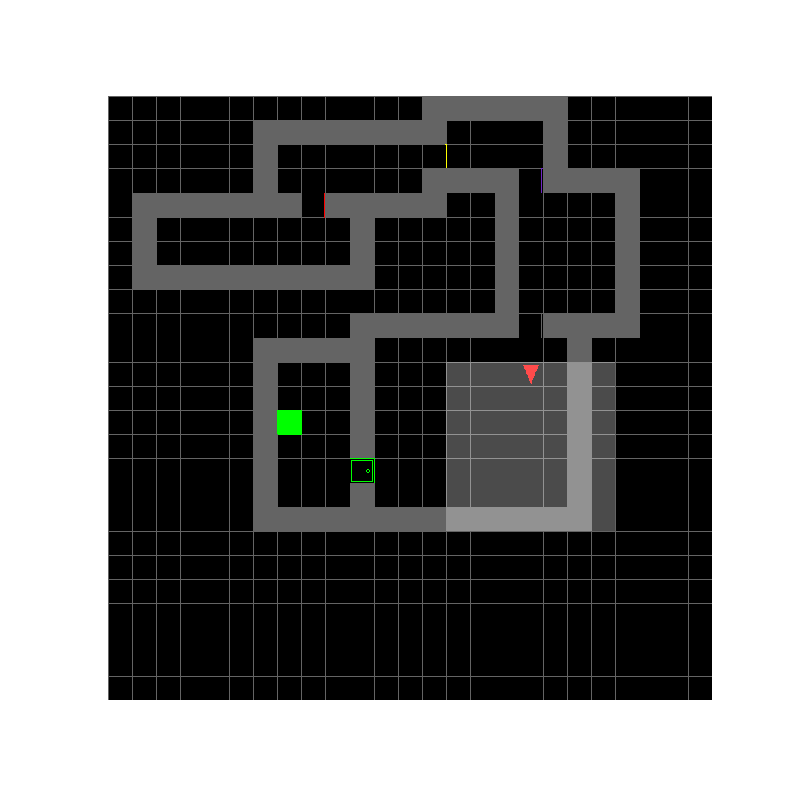
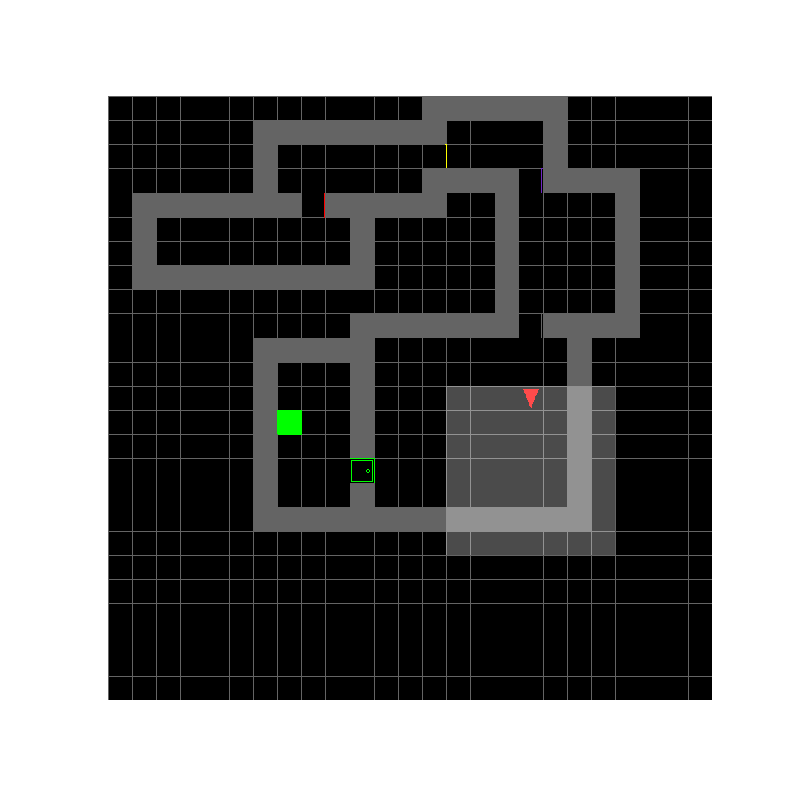
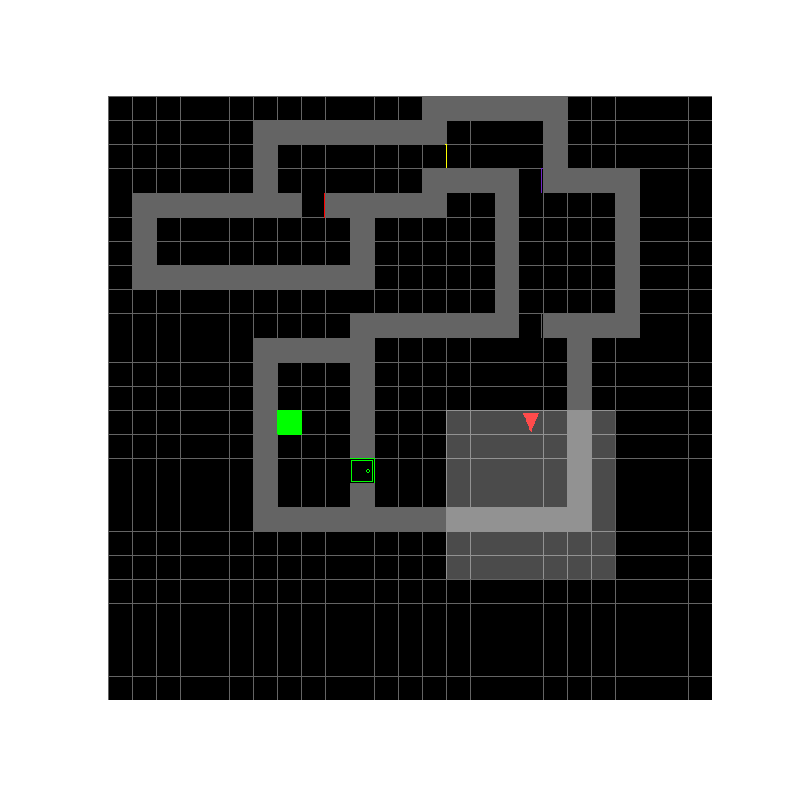
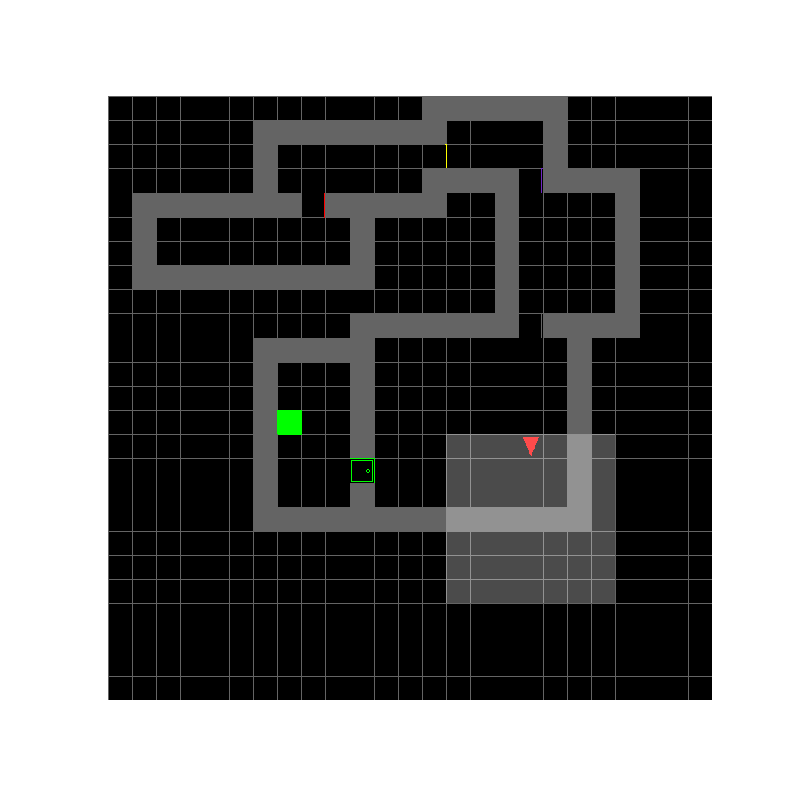
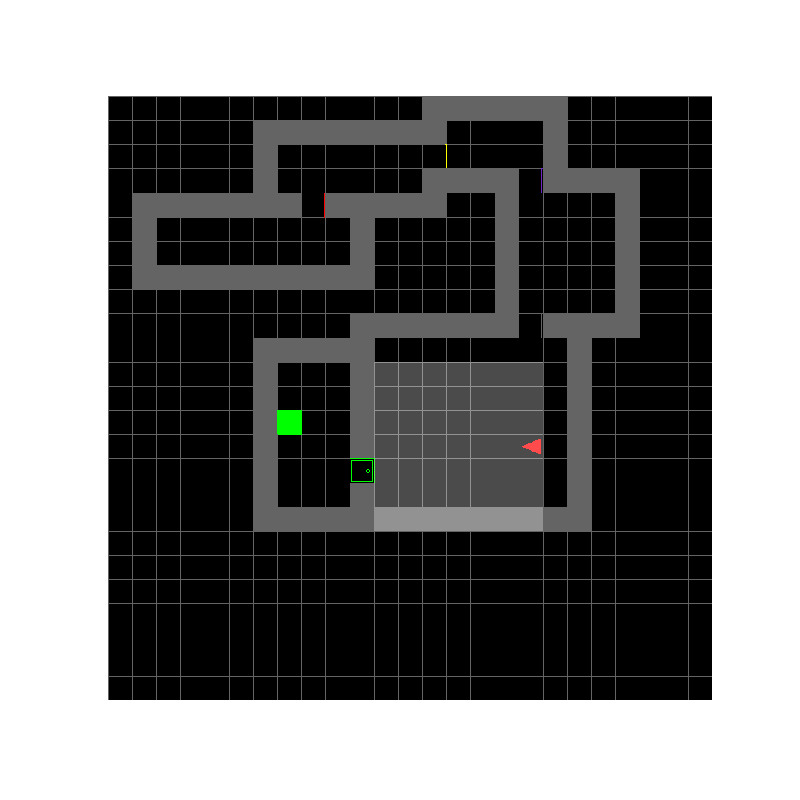
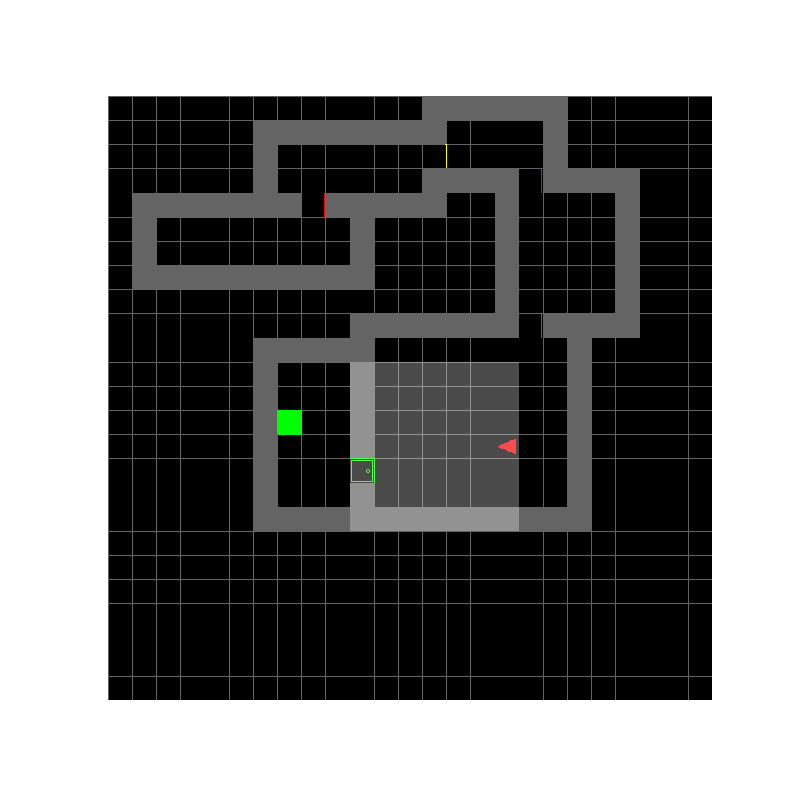
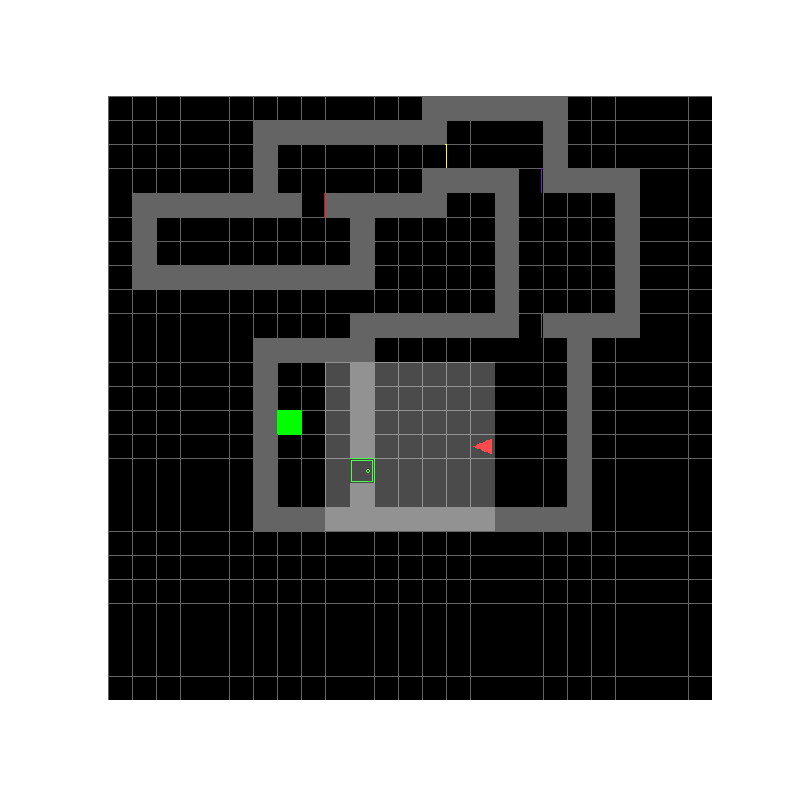
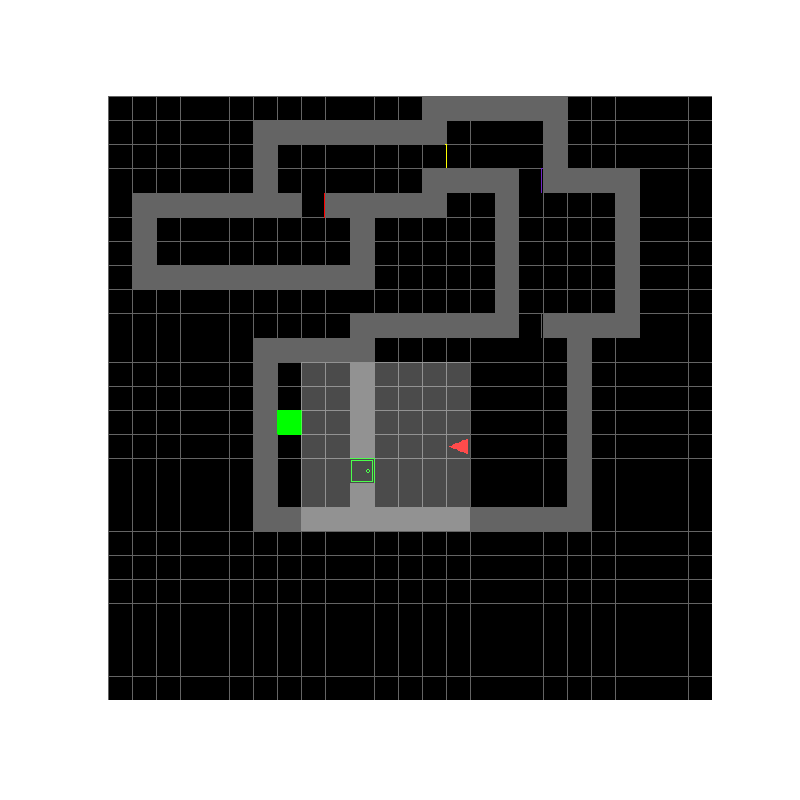
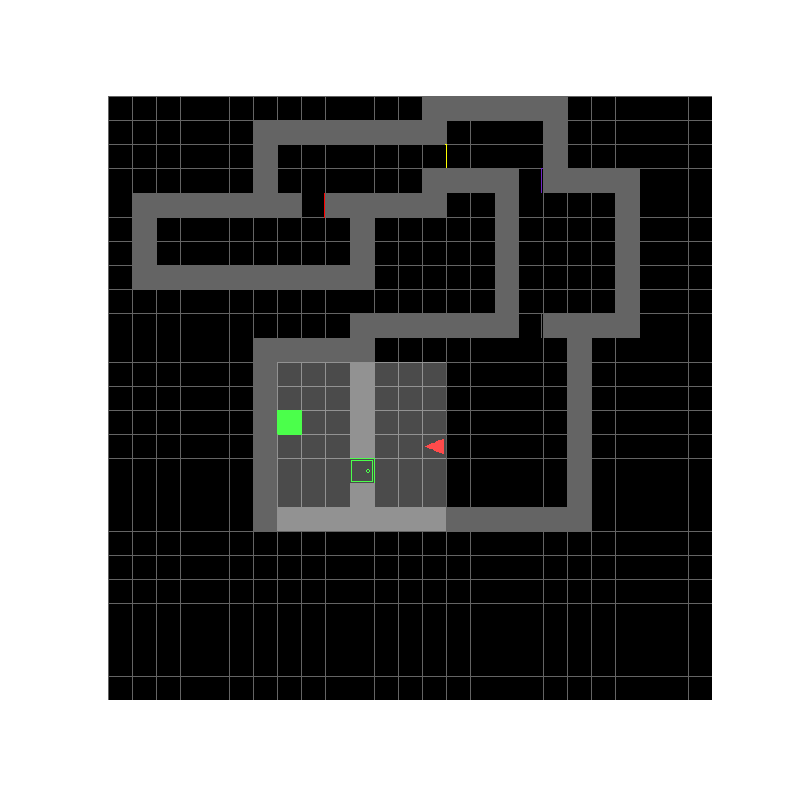
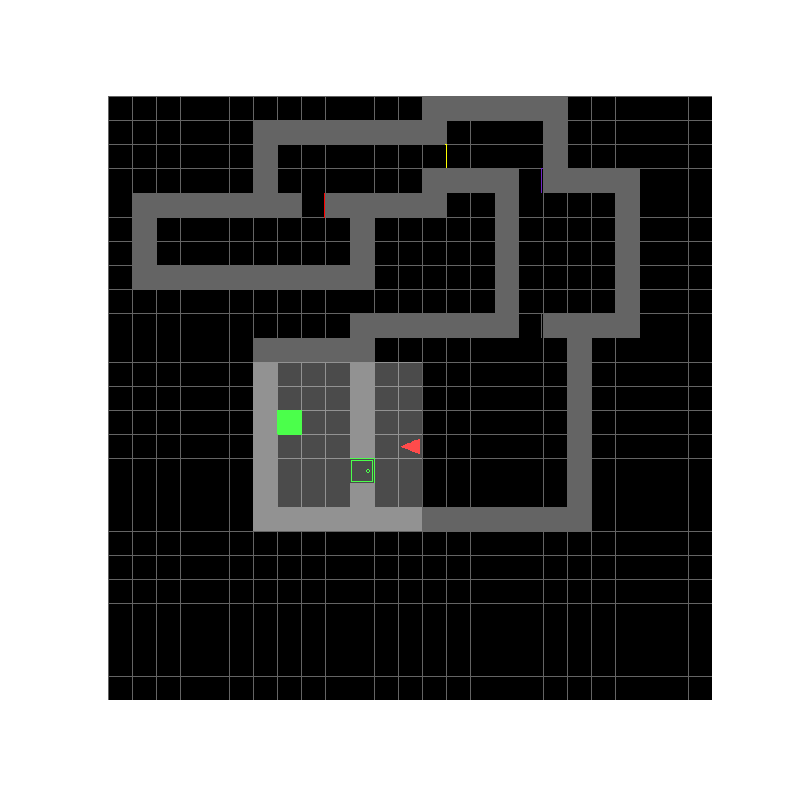
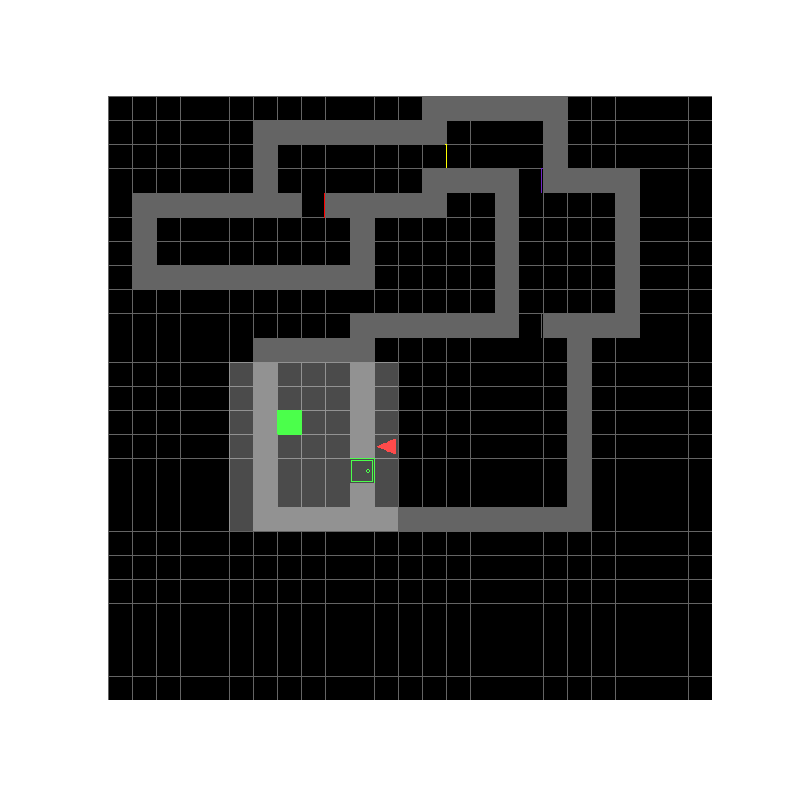
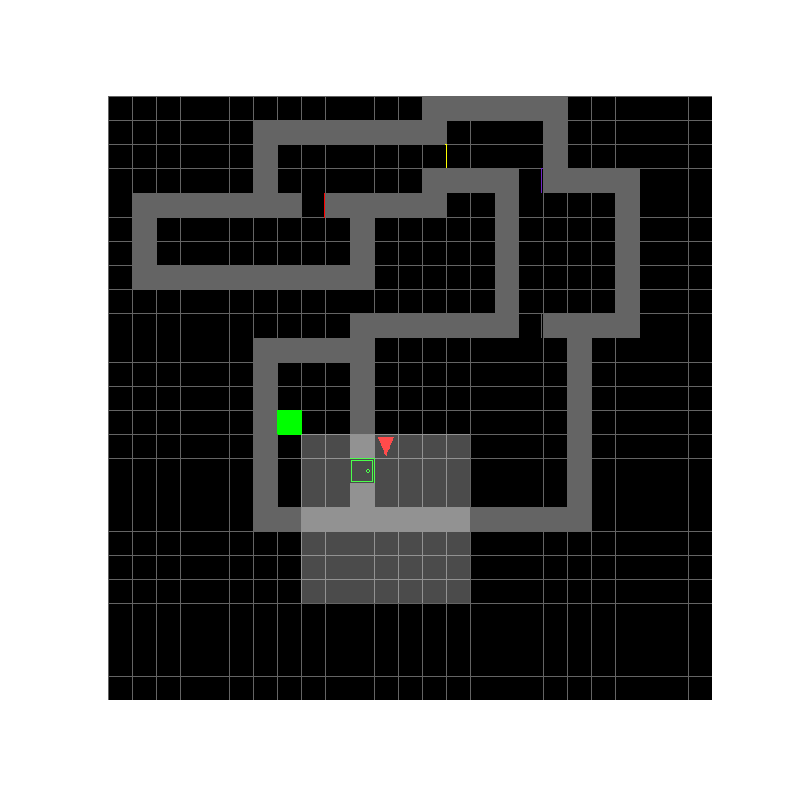
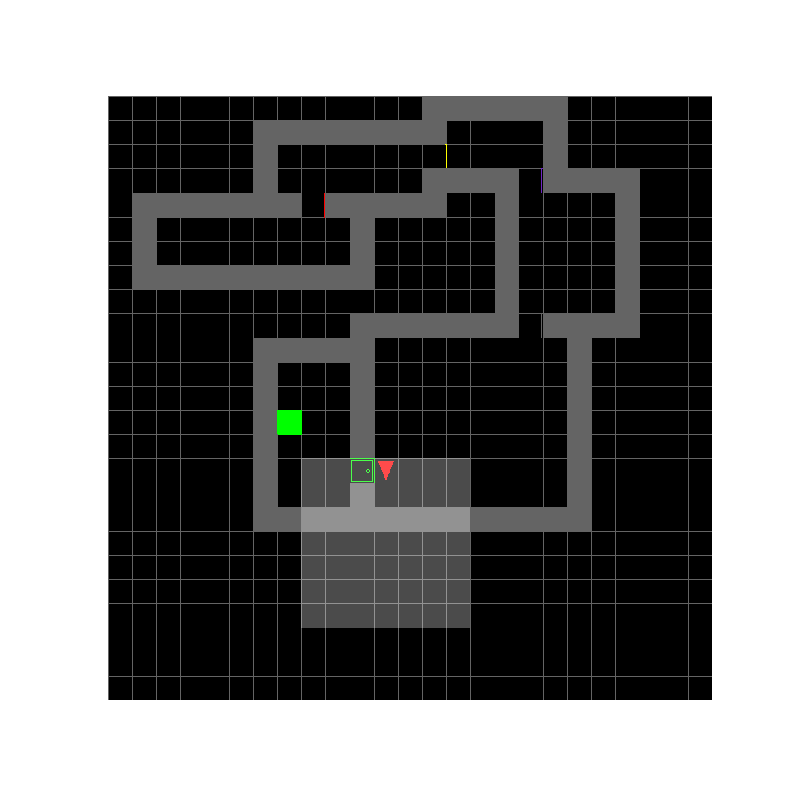
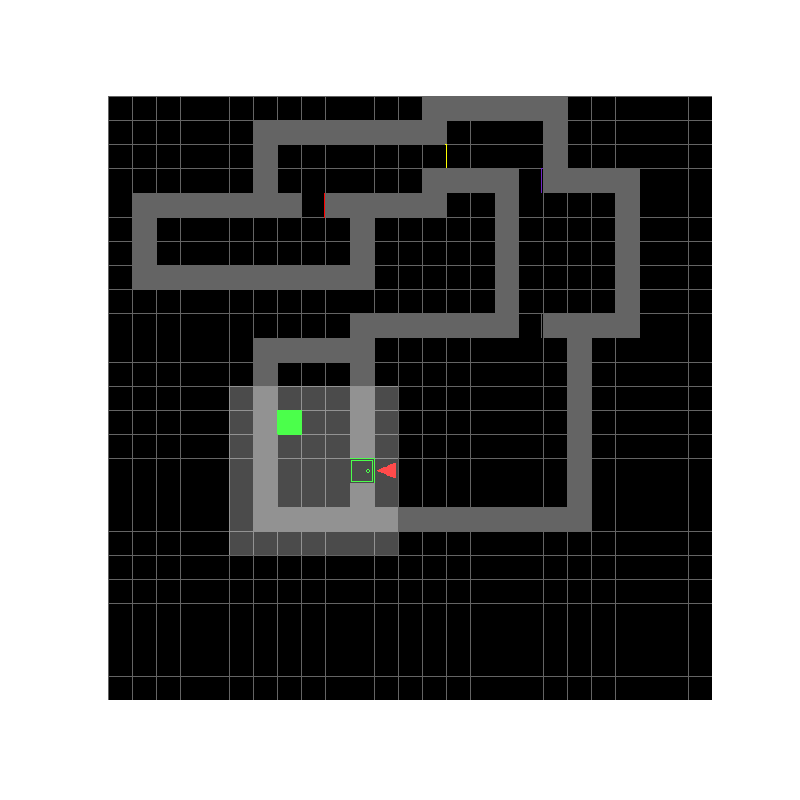
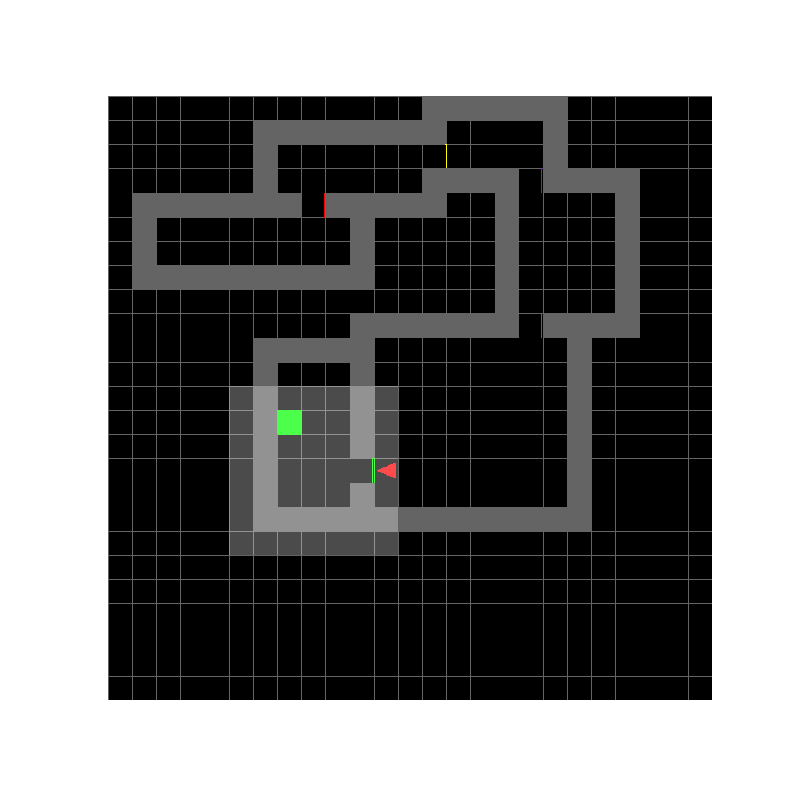
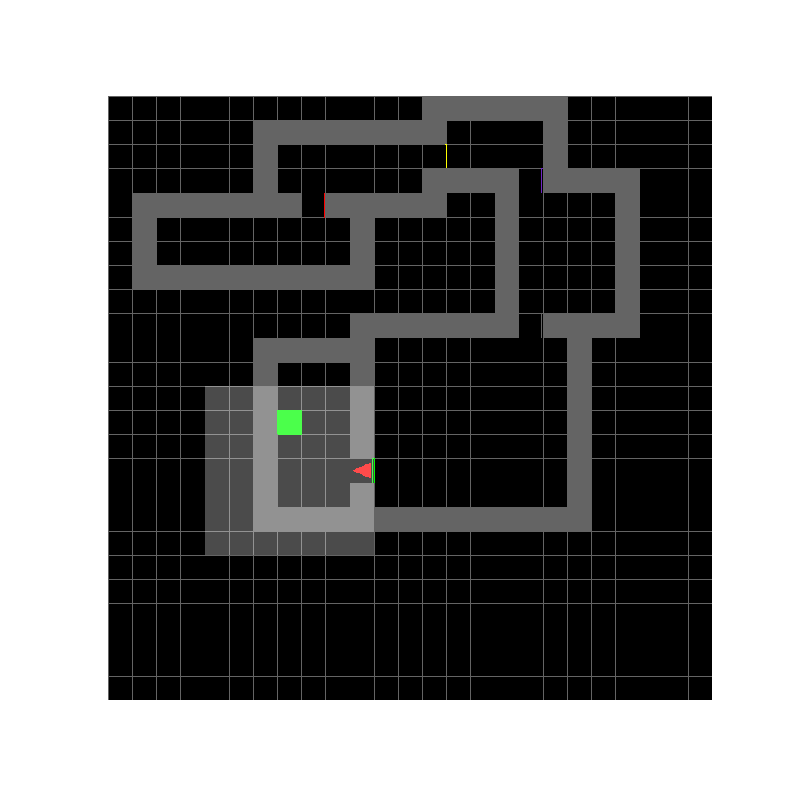
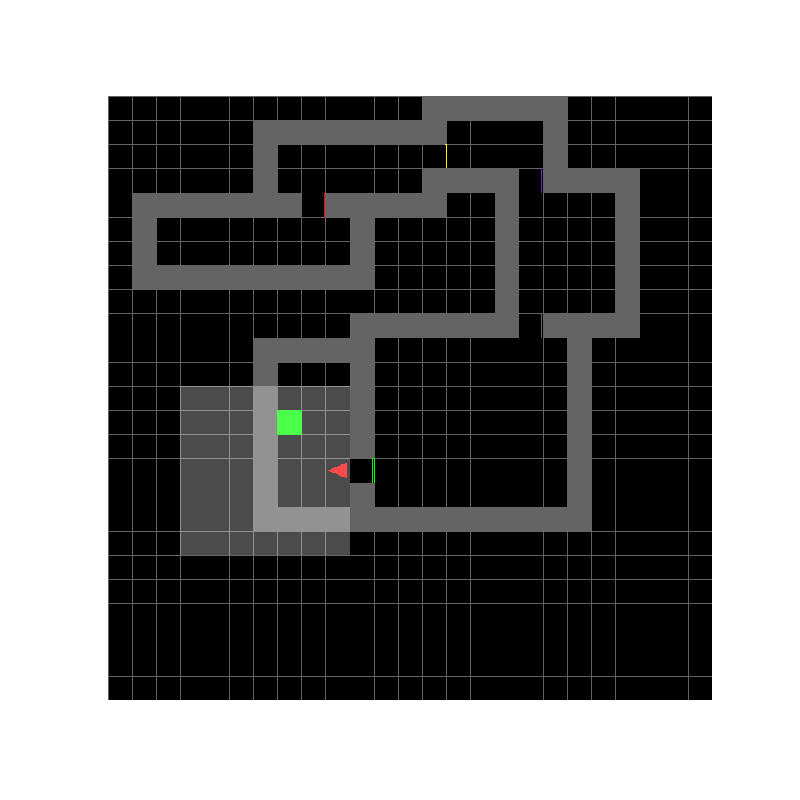
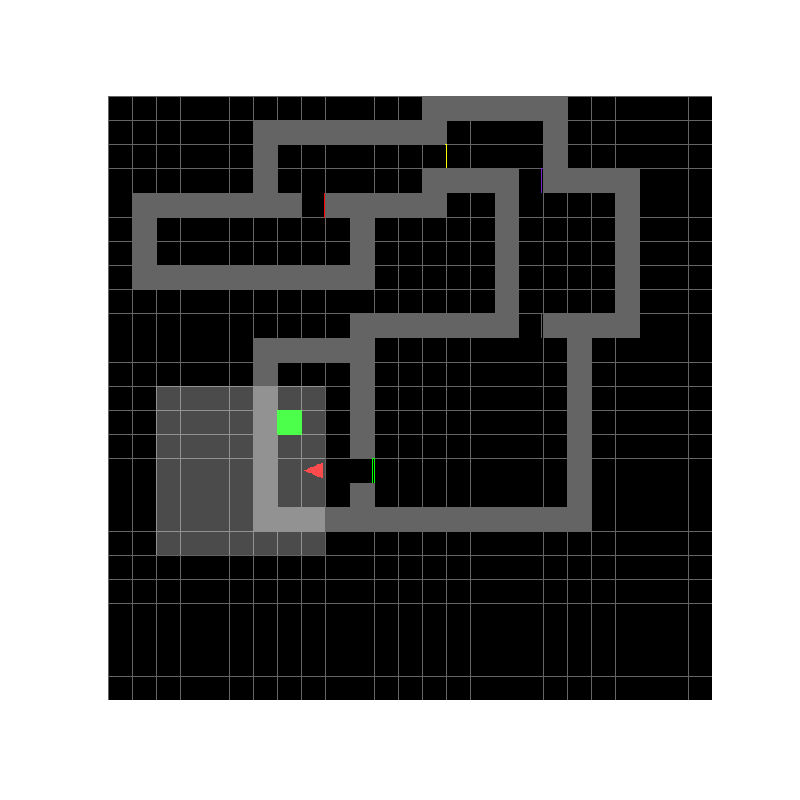
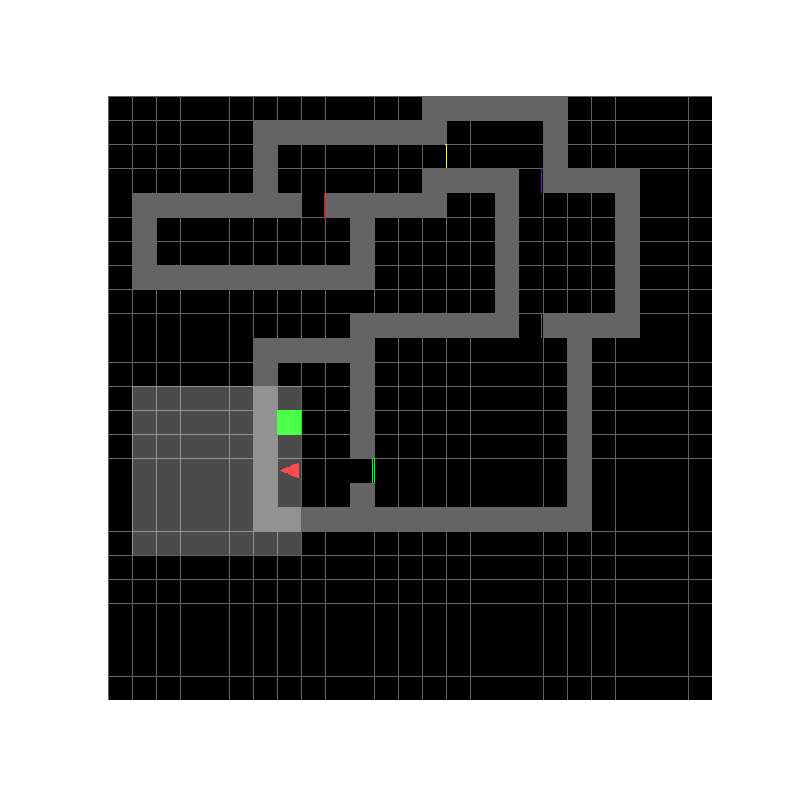
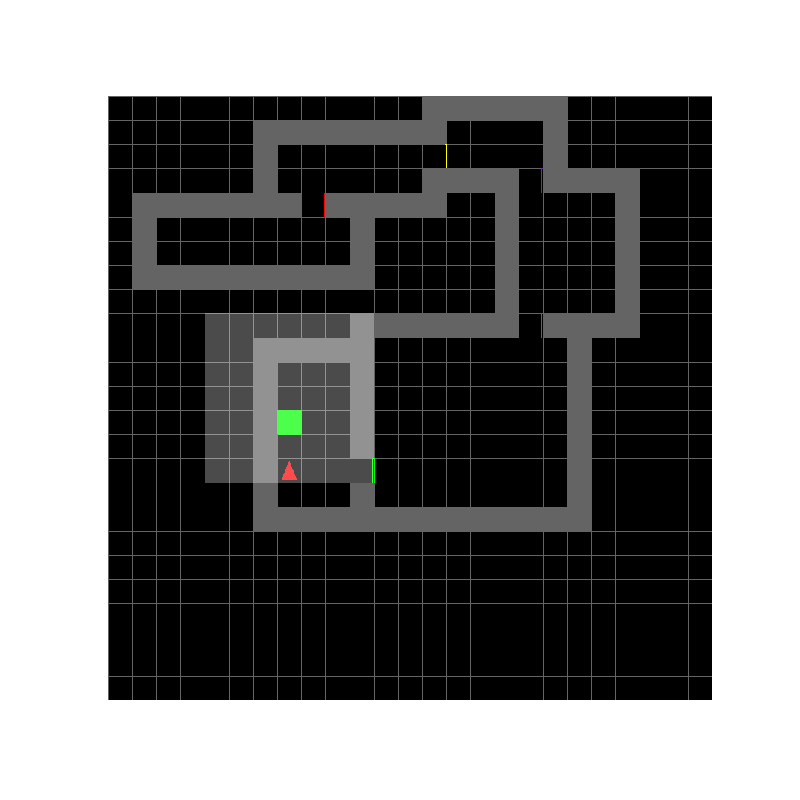
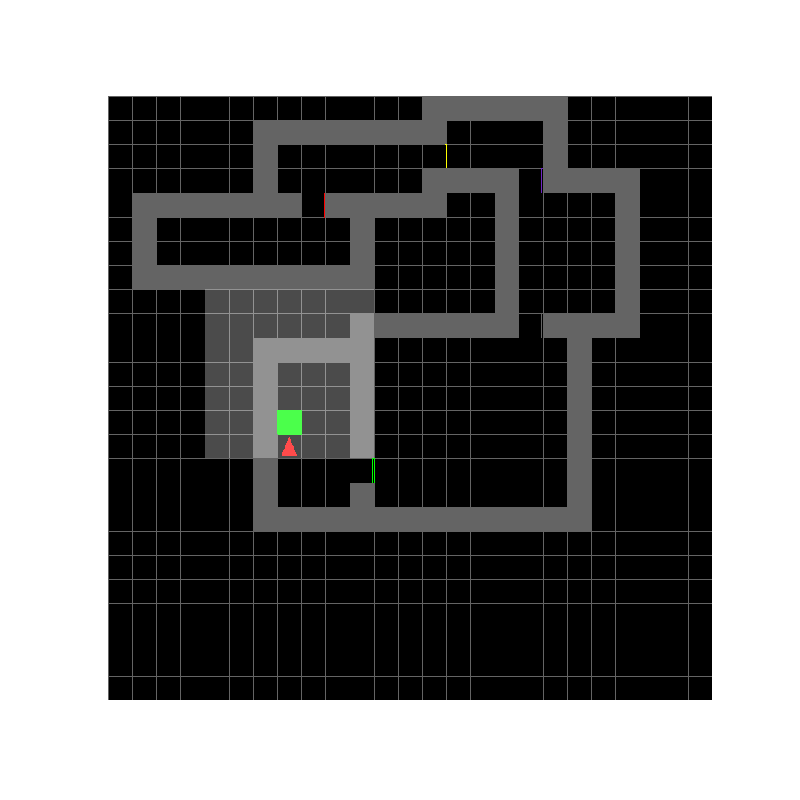
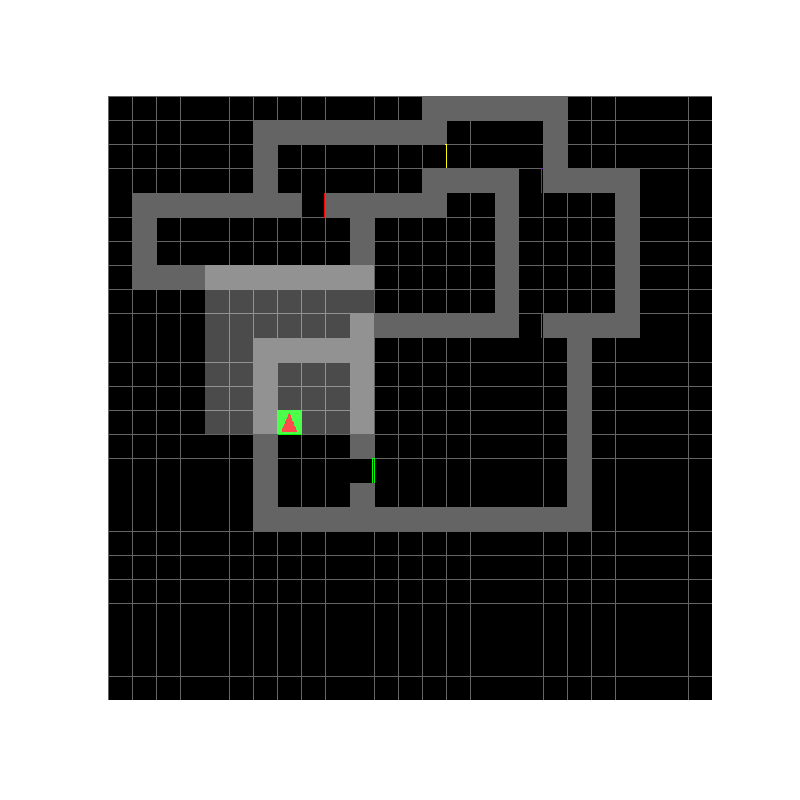

In [19]:
policy = Policy(num_actions)
load_checkpoint(policy,optimizer,'saved_models/policy_state_dicts_multiroom.pkl')
play(policy=policy,section_length=150,sample_opt =True,seed=6)